# **Application of Computer Vision on Road Data**

# Dataset & Problem Description

Self-driving cars need to be able to identify common entities on or alongside the road. The dataset "Udacity Self-Driving Car" on Roboflow provides 15000 images containing pedestrians, cars, traffic lights, bikers, etc and labels containing the coordinates for those objects. The objective of this vignettte is to train a computer vision model on the images in order to associate the labels with the correct objects. The vignette uses the YOLOv7 model to detect the different potential roadside objects and labels the objects along with the probability that the object is what it's labeled as.

## Why YOLOv7?

The YOLOv7 model was chosen as it's better at precision of small objects such as traffic lights and pedestrians, when the objects are either a long distance away or captured with a low-resolution camera. The model is also more robust when dealing with day/night lighting, weather, and information-dense images. Additionally, implementing it via PyTorch allowed for the model to be easier to fine-tune to the given traffic dataset in this vignette.

# Basic Setup

1.   Clone YOLOv7
2.   Load Pretrained Model
3.   Download Dataset
4.   Split test/train
5.   Sample Labeling on a image



In [ ]:
# Installing PYTorch and connecting it to a GPU from a server PC
!pip install "torch<2.6" "torchvision<0.21"
import torch
print("CUDA available:", torch.cuda.is_available())
print("GPU name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")

### YOLO V7 Repository Clone

In [ ]:
# Monitors the status of the GPU.
!nvidia-smi

# 1) Clone YOLOv7 repo
!git clone https://github.com/WongKinYiu/yolov7.git
%cd yolov7

# 2) Install requirements
!sed -i '/numpy/d' requirements.txt
!grep -i numpy requirements.txt

!pip install --upgrade pip
!pip install -r requirements.txt

### Pre Trained Model YOLOv7

The advantage of using a pre-trained YOLOv7 model  is the amount of time saved from having pre-determined weights that can be fine-tuned to apply to detecting cars, pedestrians, etc. versus determining the weights from scratch.

**Base YOLOv7 weights**

```
!wget https://github.com/WongKinYiu/yolov7/releases/download/v0.1/yolov7.pt
```




In [ ]:
# Change directory to the YOLOv7 Model
%cd /content/yolov7

# Download base YOLOv7 weights
# !wget -nc https://github.com/WongKinYiu/yolov7/releases/download/v0.1/yolov7.pt
!wget -nc https://github.com/WongKinYiu/yolov7/releases/download/v0.1/yolov7-tiny.pt

!ls -lh yolov7*.pt

### Manual Dataset Download - commented out as the preferred method is to use the api key.



https://public.roboflow.com/object-detection/self-driving-car

In [ ]:
# # ===== Shenyi: Manual upload & extract YOLOv7 dataset =====

# import os
# from google.colab import files
# import zipfile

# # Upload the YOLOv7 dataset zip
# uploaded = files.upload()

# # Get file name
# zip_name = next(iter(uploaded))
# print("Uploaded zip:", zip_name)

# # Extract to /content/data/yolov7
# extract_dir = "/content/data/yolov7"
# os.makedirs(extract_dir, exist_ok=True)

# with zipfile.ZipFile(zip_name, "r") as zip_ref:
#     zip_ref.extractall(extract_dir)

# print("Extracted to:", extract_dir)

# # List directory to verify st



In [ ]:
# # ===== Split export/ into train/ and valid/ (Shenyi) =====
# from pathlib import Path
# import random
# import shutil
# import os

# export_root = Path("/content/data/yolov7/export")
# images_dir = export_root / "images"
# labels_dir = export_root / "labels"

# print("Images dir exists:", images_dir.exists())
# print("Labels dir exists:", labels_dir.exists())

# # 1. collect images
# image_files = sorted(list(images_dir.glob("*.jpg")) + list(images_dir.glob("*.png")))
# print("Total images:", len(image_files))

# # 2. split 80/20
# random.seed(42)
# random.shuffle(image_files)

# train_ratio = 0.8
# n_train = int(len(image_files) * train_ratio)

# train_files = image_files[:n_train]
# val_files   = image_files[n_train:]

# print(f"Train images: {len(train_files)}")
# print(f"Valid images: {len(val_files)}")

# # 3. create folders
# root = Path("/content/data/yolov7")
# for split in ["train", "valid"]:
#     for sub in ["images", "labels"]:
#         (root / split / sub).mkdir(parents=True, exist_ok=True)

# def copy_pair(img_path, split):
#     """Copy image + label into train/ or valid/ folders."""
#     dst_img = root / split / "images" / img_path.name
#     shutil.copy2(img_path, dst_img)

#     label_src = labels_dir / (img_path.stem + ".txt")
#     if label_src.exists():
#         dst_label = root / split / "labels" / label_src.name
#         shutil.copy2(label_src, dst_label)

# # 4. copy
# for img in train_files:
#     copy_pair(img, "train")

# for img in val_files:
#     copy_pair(img, "valid")

# print("Done splitting dataset.")

# # 5. check folders
# !ls -R /content/data/yolov7


### Auto Dataset Download

https://public.roboflow.com/object-detection/self-driving-car

In [ ]:
# Changing directory to the content folder and installing RoboFlow package via
# pip
%cd /content
!pip install roboflow

from google.colab import userdata
from roboflow import Roboflow

# Inputting RoboFlow API Key (found on RoboFlow) and then finding the dataset
# and downloading it
ROBOFLOW_API_KEY = "insert_api_key_here" # Key is blank for security purposes
if ROBOFLOW_API_KEY is None:
    raise ValueError("RoboflowApi is not set in Colab user data")

rf = Roboflow(api_key=ROBOFLOW_API_KEY)

project = rf.workspace("roboflow-gw7yv").project("self-driving-car")
version = project.version(3)

dataset = version.download("yolov7", location="data/yolov7")
print("Dataset location:", dataset.location)



### Dataset (train/valid split)

In [ ]:
# ===== Split export/ into train/ and valid/ =====
from pathlib import Path
import random
import shutil

export_root = Path("data/yolov7/export")
images_dir = export_root / "images"
labels_dir = export_root / "labels"

# Check if the image and label directories exist
print("Images dir exists:", images_dir.exists())
print("Labels dir exists:", labels_dir.exists())

# Sorts the images and searches for images that are in either jpg or png formats.
image_files = sorted(list(images_dir.glob("*.jpg")) + list(images_dir.glob("*.png")))
print("Total images:", len(image_files))

random.seed(42)
random.shuffle(image_files)
# Maintaining 80/20 ratio of training to validation images. Extra 5% of images for
# testing.
train_ratio = 0.20
val_ratio = 0.05
test_ratio = 0.05

n_train = int(len(image_files) * train_ratio)
n_val = int(len(image_files) * val_ratio)
n_test = int(len(image_files) * test_ratio)

train_files = image_files[:n_train]
val_files   = image_files[n_train : n_train + n_val]
test_files  = image_files[n_train + n_val : n_train + n_val + n_test]

print(f"Train images: {len(train_files)}")
print(f"Validation images: {len(val_files)}")
print(f"Test images: {len(test_files)}")

# data/yolov7/train|valid|test/{images,labels}
root = Path("data/yolov7")
for split in ["train", "valid", "test"]:
    for sub in ["images", "labels"]:
        # Clear existing directories before recreating
        shutil.rmtree(root / split / sub, ignore_errors=True)
        (root / split / sub).mkdir(parents=True, exist_ok=True)

def copy_pair(img_path: Path, split: str):
    """Copy image and its label (if it exists) into train/ or valid/."""
    dst_img = root / split / "images" / img_path.name
    shutil.copy2(img_path, dst_img)

    label_src = labels_dir / (img_path.stem + ".txt")
    if label_src.exists():
        dst_label = root / split / "labels" / label_src.name
        shutil.copy2(label_src, dst_label)

for img in train_files:
    copy_pair(img, "train")

for img in val_files:
    copy_pair(img, "valid")

for img in test_files:
    copy_pair(img, "test")

print("Done splitting dataset.")

Images dir exists: True
Labels dir exists: True
Total images: 29800
Train images: 5960
Validation images: 1490
Test images: 1490
Done splitting dataset.


In [ ]:
# Changing directory to YOLOv7
%cd /content/yolov7
# Constructing yaml file that indicates where the images are located and the
# categories of objects that can be encountered in the images.
data_yaml = """
train: /content/data/yolov7/train/images
val: /content/data/yolov7/valid/images
test: /content/data/yolov7/test/images

nc: 11
names:
  - biker
  - car
  - pedestrian
  - trafficLight
  - trafficLight-Green
  - trafficLight-GreenLeft
  - trafficLight-Red
  - trafficLight-RedLeft
  - trafficLight-Yellow
  - trafficLight-YellowLeft
  - truck
"""

with open("self_driving_data.yaml", "w") as f:
    f.write(data_yaml)

print("Wrote config to /content/yolov7/self_driving_data.yaml")

/content/yolov7
Wrote config to /content/yolov7/self_driving_data.yaml


### Sample Labeling

In [ ]:
import yaml
# Loading data_yaml and defining the class names
data_config = yaml.safe_load(data_yaml)
names = data_config['names']
train_images_dir = Path("/content/data/yolov7/train/images")

print("Class names:", names)

Class names: ['biker', 'car', 'pedestrian', 'trafficLight', 'trafficLight-Green', 'trafficLight-GreenLeft', 'trafficLight-Red', 'trafficLight-RedLeft', 'trafficLight-Yellow', 'trafficLight-YellowLeft', 'truck']


Number of train images found: 5960
Showing: /content/data/yolov7/train/images/1478899425472593293_jpg.rf.d8a26a44a611e41f7fd8d01b26a29c9a.jpg


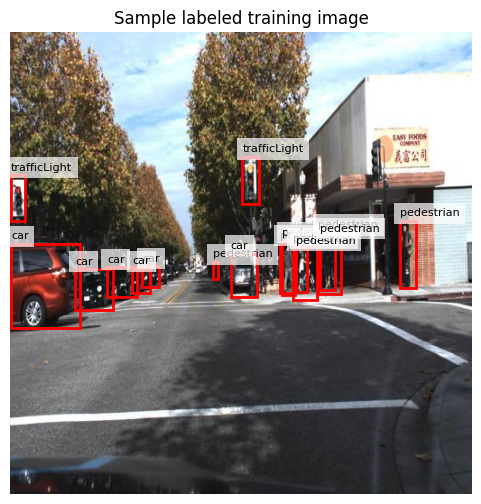

In [ ]:
import random
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
# Labels an image from its image path.
def load_image_and_labels(img_path: Path):
    label_path = Path(str(img_path).replace("images", "labels")).with_suffix(".txt")
    boxes = []
    if label_path.exists():
        with open(label_path, "r") as f:
            for line in f:
                parts = line.strip().split()
                cls_id = int(parts[0])
                x_c, y_c, w, h = map(float, parts[1:])
                boxes.append((cls_id, x_c, y_c, w, h))
    return Image.open(img_path).convert("RGB"), boxes
# Plots the label box on the object in the image
def plot_one_labeled_image(img_path: Path, class_names):
    img, boxes = load_image_and_labels(img_path)
    W, H = img.size

    fig, ax = plt.subplots(figsize=(6, 6))
    ax.imshow(img)

    for cls_id, x_c, y_c, w, h in boxes:
        x_c *= W; y_c *= H
        w *= W;  h *= H
        x0 = x_c - w / 2
        y0 = y_c - h / 2

        rect = patches.Rectangle(
            (x0, y0),
            w, h,
            linewidth=2,
            edgecolor="r",
            facecolor="none",
        )
        ax.add_patch(rect)

        label = class_names[cls_id]
        ax.text(
            x0, max(y0 - 5, 0),
            label,
            fontsize=8,
            bbox=dict(facecolor="white", alpha=0.7, edgecolor="none"),
        )

    ax.axis("off")
    plt.title("Sample labeled training image")
    plt.show()
# Lists all the training images
train_images = list(train_images_dir.glob("*.jpg")) + list(train_images_dir.glob("*.png"))
print("Number of train images found:", len(train_images))

# Take a random image from the set of training images and plot a label on the
# detected object from the class of potential road-side objects.
sample_img = random.choice(train_images)
print("Showing:", sample_img)
plot_one_labeled_image(sample_img, names)

data/yolov7/data.yaml

```
names:
- biker
- car
- pedestrian
- trafficLight
- trafficLight-Green
- trafficLight-GreenLeft
- trafficLight-Red
- trafficLight-RedLeft
- trafficLight-Yellow
- trafficLight-YellowLeft
- truck
nc: 11
train: /content/data/yolov7/train/images
val: /content/data/yolov7/valid/images
test: /content/data/yolov7/test/images
```



# Fine-tuning YOLOv7-Tiny on the Self-Driving Car Dataset


## Experiment 1 (with raw data)

In [ ]:
import os
os.environ["WANDB_DISABLED"] = "true"
# Loads the weights onto the image-training python file.
# Ultimately builds the training model with weights that can be applied to images
# in the self-driving car data set.
%cd /content/yolov7
!grep -n "torch.load(weights, map_location=device)" train.py
!sed -i "s/torch.load(weights, map_location=device)/torch.load(weights, map_location=device, weights_only=False)/g" train.py
!grep -n "torch.load(weights" train.py


/content/yolov7
71:        run_id = torch.load(weights, map_location=device, weights_only=False).get('wandb_id') if weights.endswith('.pt') and os.path.isfile(weights) else None
87:        ckpt = torch.load(weights, map_location=device, weights_only=False)  # load checkpoint




### Model Training


In [ ]:
# Changing directory to YOLOv7
%cd /content/yolov7

EXP_NAME = "car-vision-yolov7-finetune"

# Runs the training model on a subset of the images, where the self_driving_data
# yaml contains the different classifications of objects (cars, traffic lights,
# pedestrians, etc.)
# The results of the experiment are assigned to the object EXP_name.
!python train.py \
  --img 512 \
  --batch 4 \
  --epochs 5 \
  --data /content/yolov7/self_driving_data.yaml \
  --cfg cfg/training/yolov7-tiny.yaml \
  --weights yolov7-tiny.pt \
  --name {EXP_NAME}

### Model Evaluation


### Objectives

*   Show metrics such as Mean Average Precision (mAP), precision, recall etc.
*   Show F1 Curve (relationship between confidence threshold and F1 Score) and Confusion matrix (relationship between predicted and actual classification of the Object). <br>

    * Note: The F1 Score is the harmonic mean of the precision and recall metrics.

#### Training Metrics


--- Training Metrics (car-vision-yolov7-finetune) ---
       0/4    0.218G   0.06776  0.009741   0.01574   0.09324        28       512    0.5497    0.1629    0.1215   0.04581   0.08308   0.02093   0.02284
       1/4    0.514G   0.05239  0.009126  0.009302   0.07081        23       512    0.3927    0.2458    0.1711   0.06898   0.07149    0.0228    0.0188
       2/4    0.612G   0.04788  0.008953  0.007312   0.06415        86       512    0.4946    0.2508    0.1999   0.08033   0.07187    0.0214   0.01723
       3/4    0.612G   0.04465  0.008902  0.006356   0.05991         5       512    0.5789    0.2565    0.2461    0.1086   0.06906   0.02045    0.0149
       4/4    0.612G   0.04343  0.008524   0.00598   0.05793         7       512    0.6088    0.2662    0.2671    0.1184   0.06858    0.0211   0.01441


--- Training Results Plot (car-vision-yolov7-finetune) ---


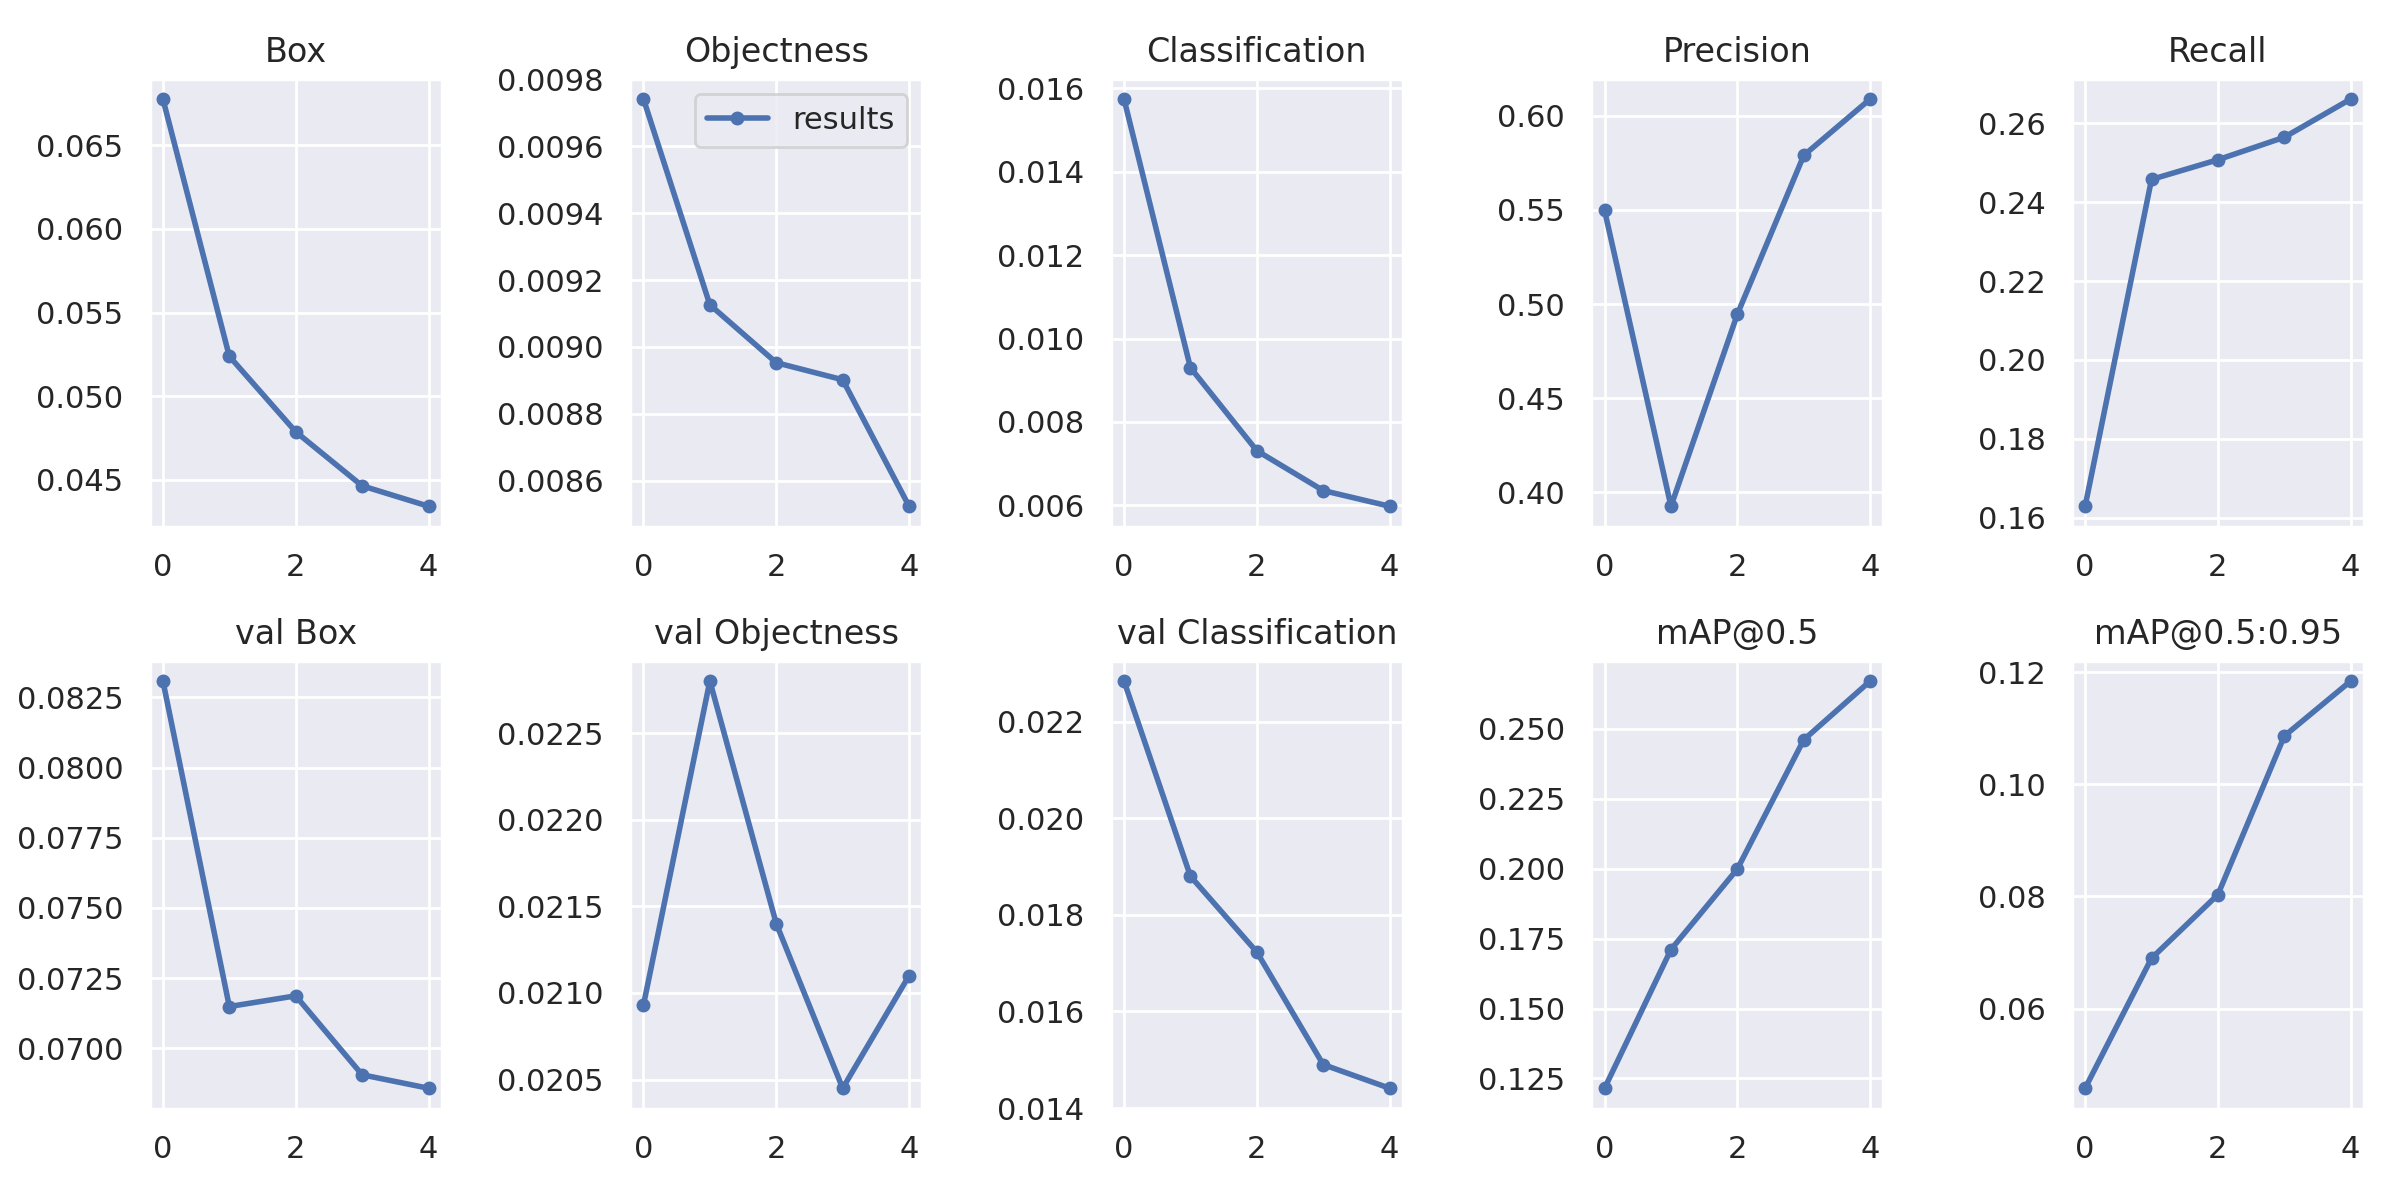


--- Confusion Matrix (car-vision-yolov7-finetune) ---


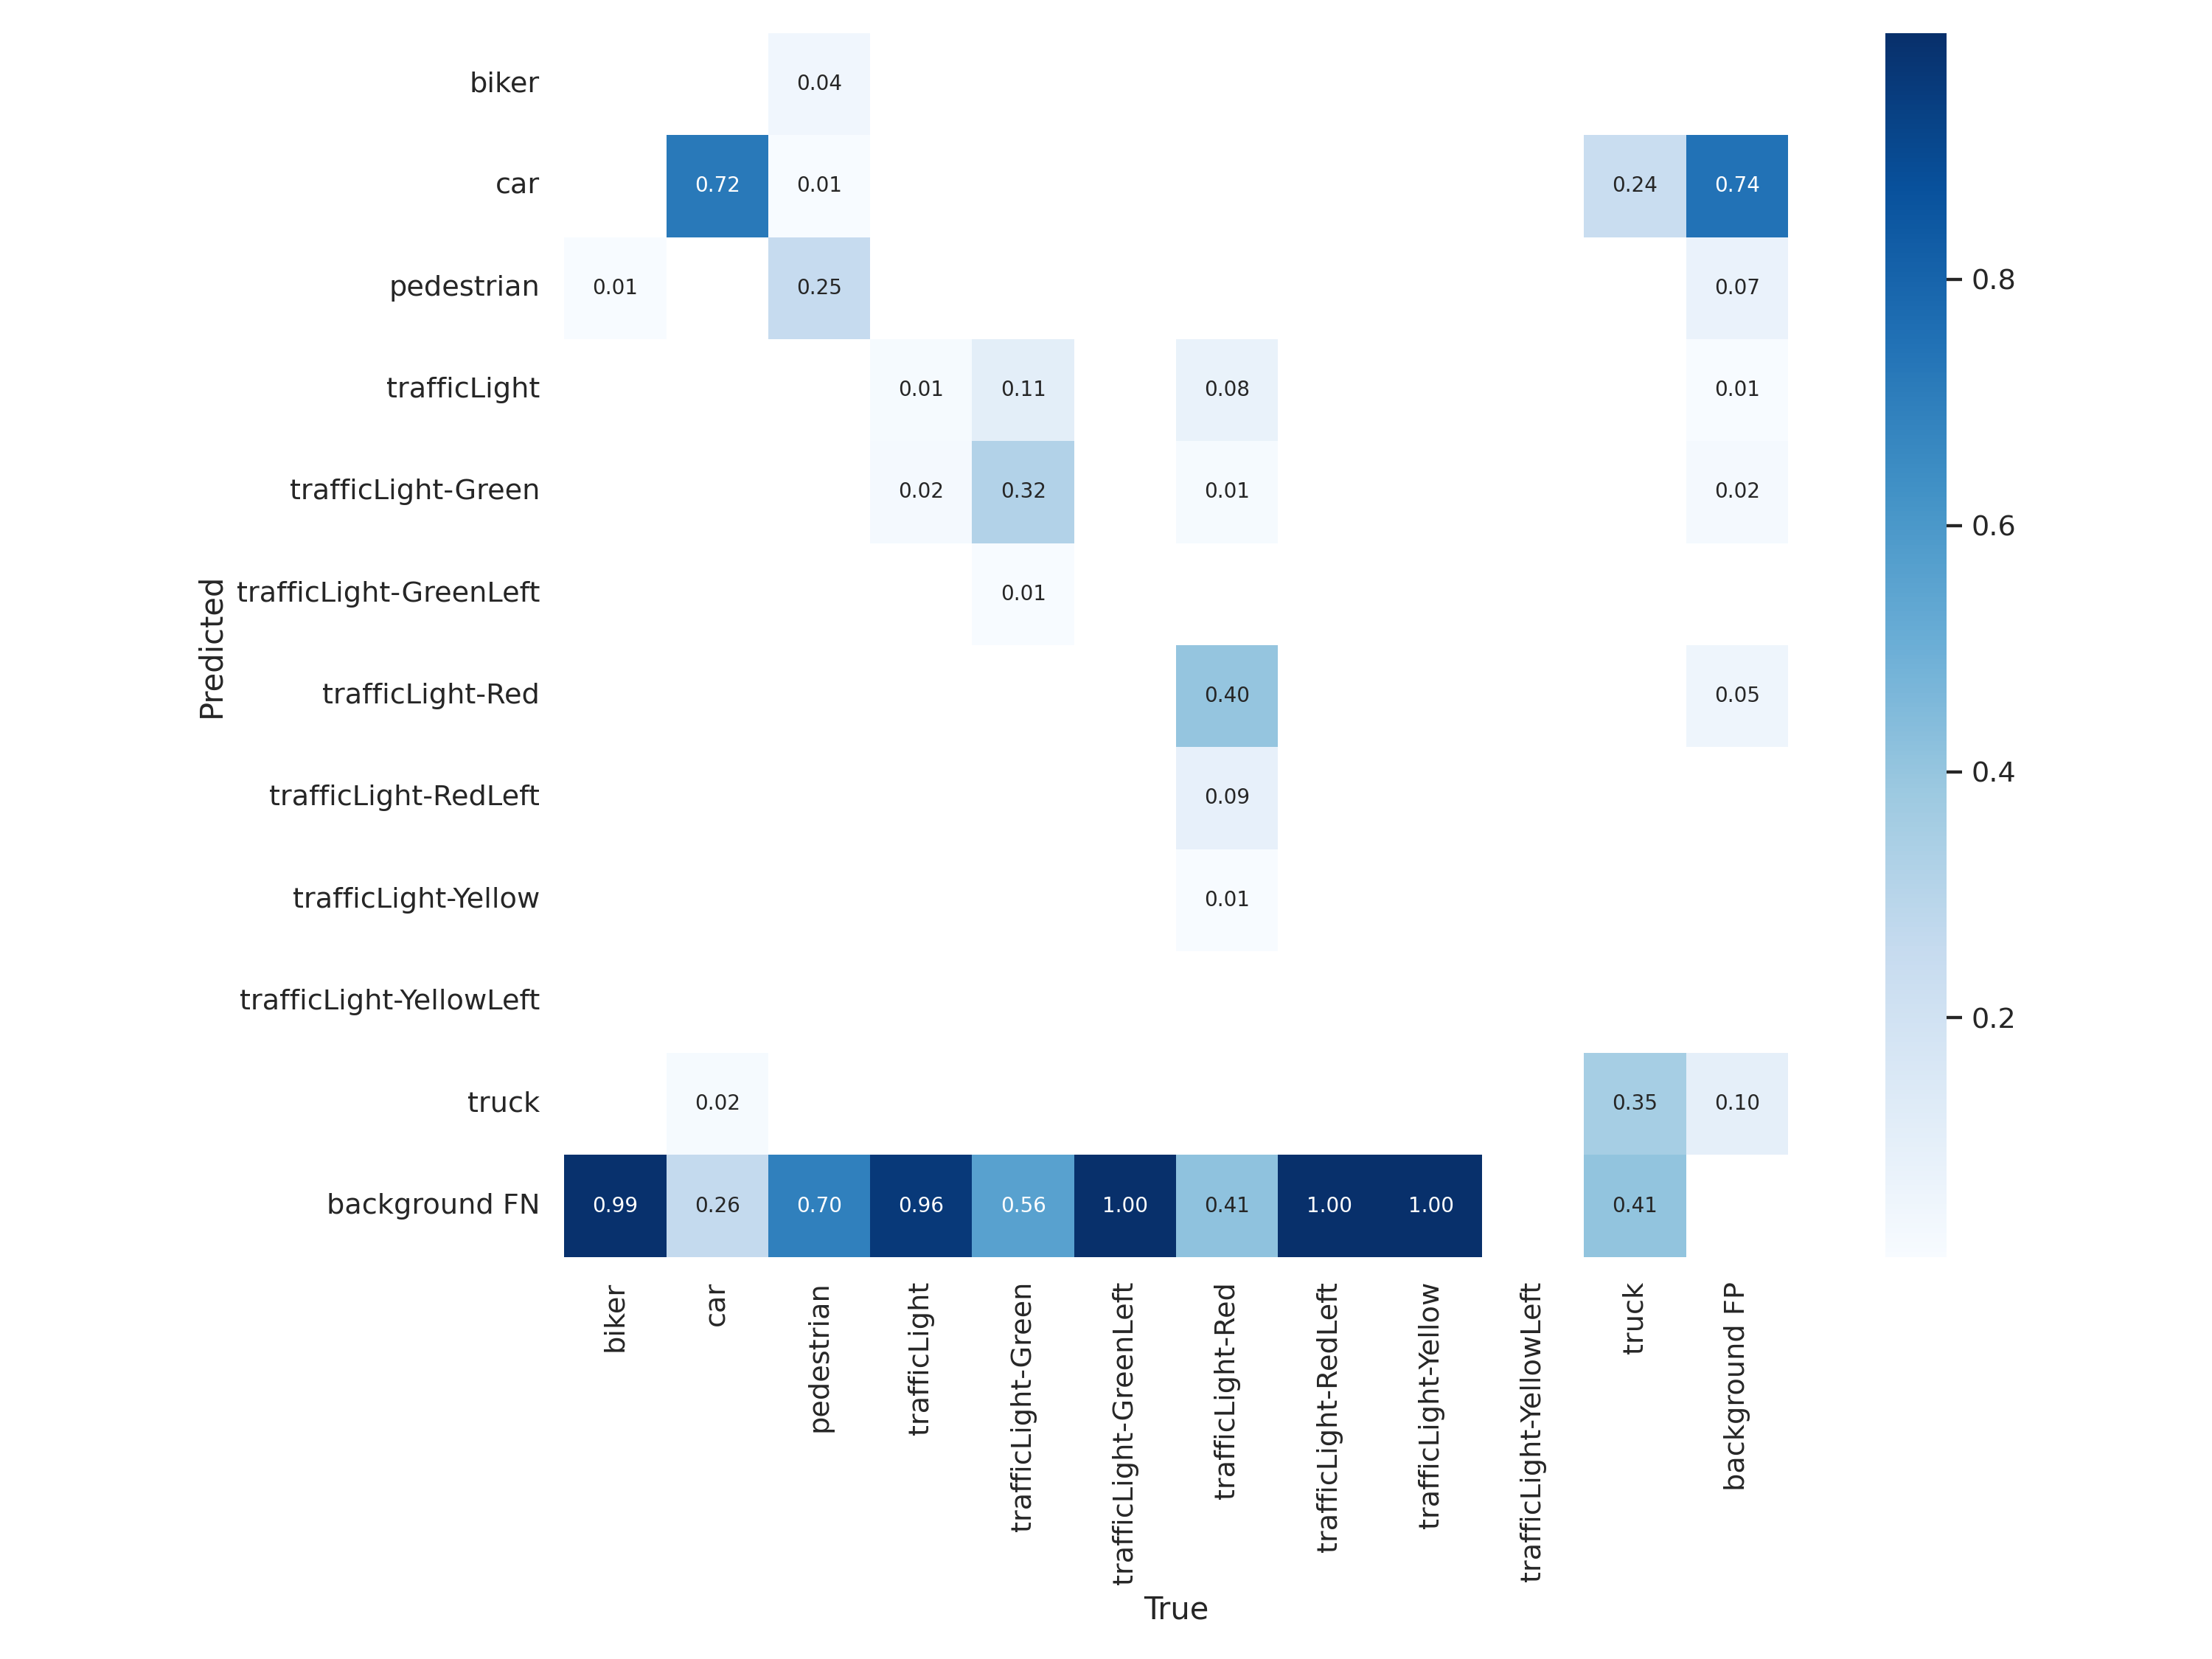


--- F1 Curve (car-vision-yolov7-finetune) ---


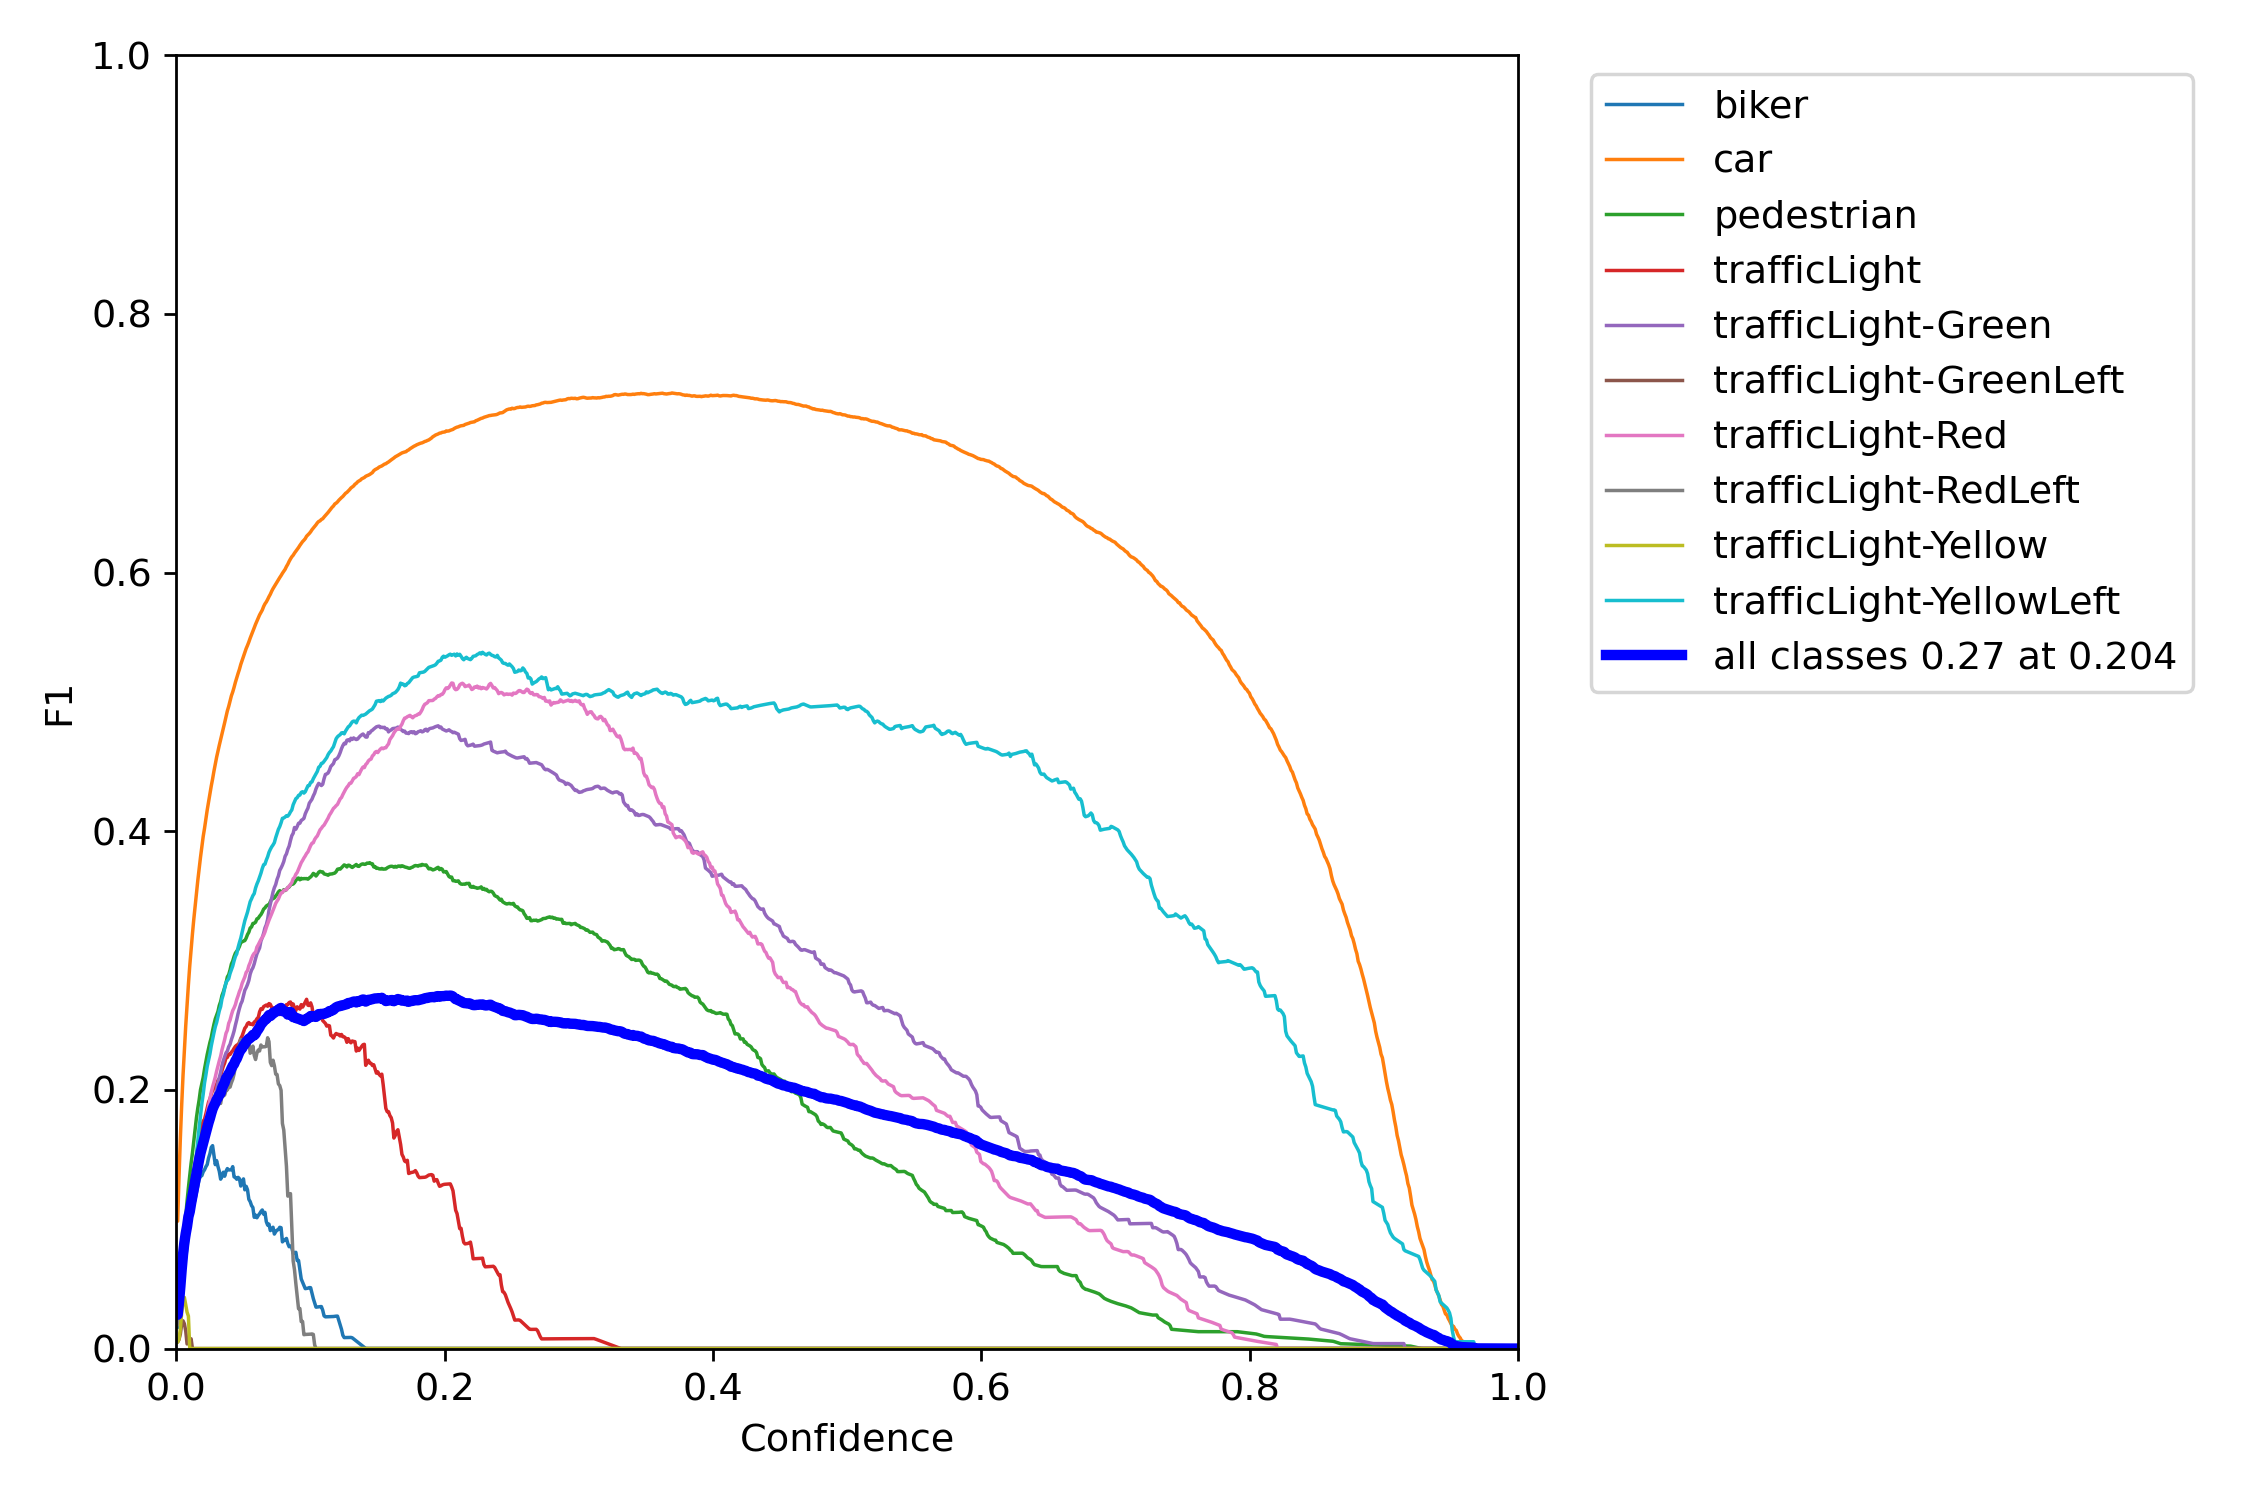

In [ ]:
# evaluate the model
#   Show metrics (mAP, precision/recall) if available.
#   Show loss curve or final results.

import os
from IPython.display import Image, display

results_dir = os.path.join('/content/yolov7/runs/train', EXP_NAME)

# Display training metrics from results.txt
results_file = os.path.join(results_dir, 'results.txt')
if os.path.exists(results_file):
    print(f"\n--- Training Metrics ({EXP_NAME}) ---")
    with open(results_file, 'r') as f:
        print(f.read())
else:
    print(f"Results file not found: {results_file}")

# Display results plot (loss curves, mAP, etc.)
results_plot = os.path.join(results_dir, 'results.png')
if os.path.exists(results_plot):
    print(f"\n--- Training Results Plot ({EXP_NAME}) ---")
    display(Image(filename=results_plot, width=800))
else:
    print(f"Results plot not found: {results_plot}")

# Optionally, display confusion matrix and F1 curve if available
confusion_matrix_plot = os.path.join(results_dir, 'confusion_matrix.png')
if os.path.exists(confusion_matrix_plot):
    print(f"\n--- Confusion Matrix ({EXP_NAME}) ---")
    display(Image(filename=confusion_matrix_plot, width=800))

F1_curve_plot = os.path.join(results_dir, 'F1_curve.png')
if os.path.exists(F1_curve_plot):
    print(f"\n--- F1 Curve ({EXP_NAME}) ---")
    display(Image(filename=F1_curve_plot, width=800))


#### Inference on Validation Set

In [ ]:
# Tuning weights to the validation set of images
!python detect.py \
  --source /content/data/yolov7/valid/images \
  --weights runs/train/car-vision-yolov7-finetune/weights/best.pt \
  --project runs/detect \
  --name car-vision-yolov7-finetune-results


Image: 1478021017721193713_jpg.rf.0bd7f8d44994d6ec68ca5212a2b16cd2.jpg


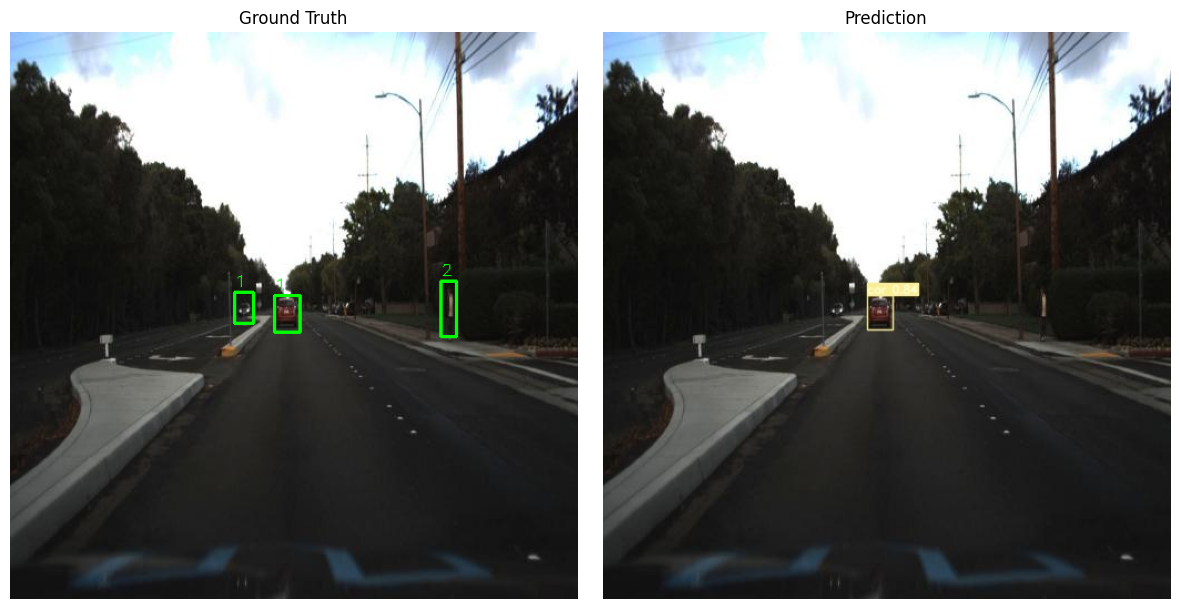


Image: 1478898744496484375_jpg.rf.f1f7f05460adfc5751e6484b1788dff1.jpg


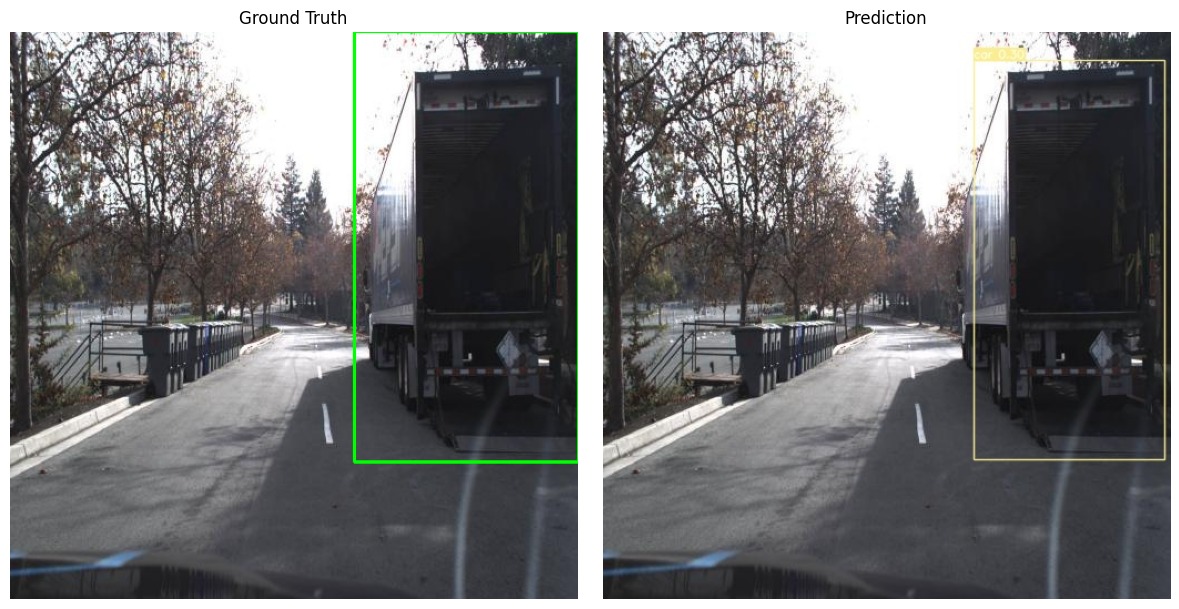


Image: 1478899484888005857_jpg.rf.1f080176c377c4ab4845c7968f91957c.jpg


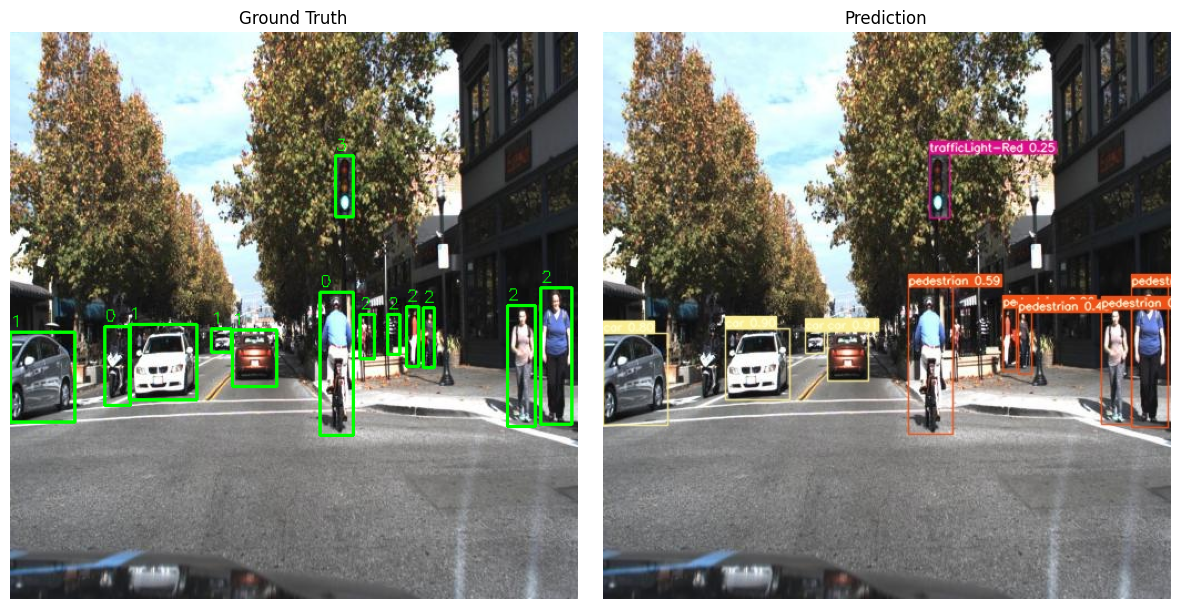


Image: 1478897657331401566_jpg.rf.cb326fbdafb5675d24493a39de31df88.jpg


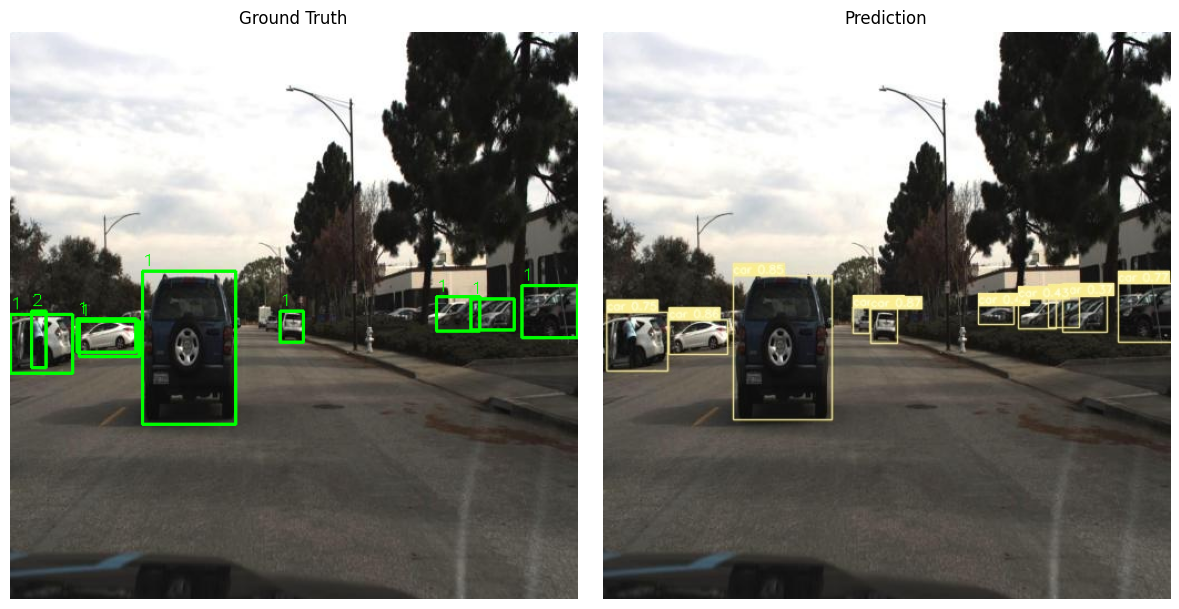


Image: 1478021008215099001_jpg.rf.CYoiASNXR7AhWMrRfDkN.jpg


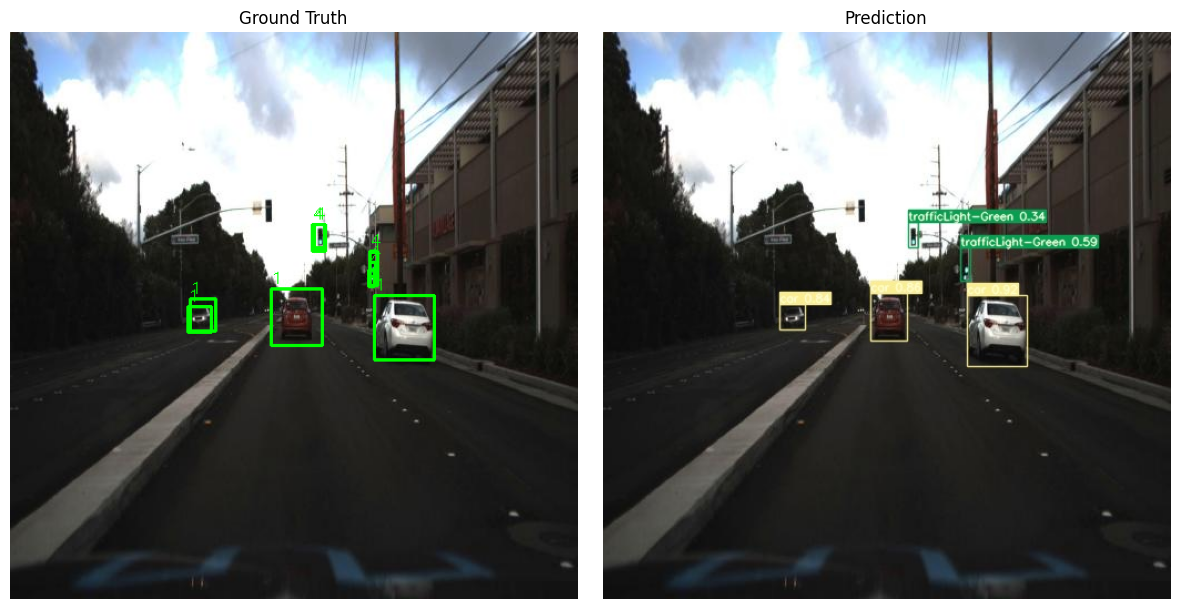

In [ ]:


import cv2
import matplotlib.pyplot as plt
from pathlib import Path
import random

# Sets up the paths for the validation images and labels along with a directory
# for the models predictions on the validation set.
valid_img_dir = Path("/content/data/yolov7/valid/images")
valid_lbl_dir = Path("/content/data/yolov7/valid/labels")
pred_dir      = Path(f"runs/detect/{EXP_NAME}-results")

# Collect all validation images
val_images = list(valid_img_dir.glob("*.jpg")) + list(valid_img_dir.glob("*.png"))

def load_yolo_labels(label_path: Path, img_w: int, img_h: int):
    """
    Load YOLO-format labels (class x_center y_center width height, all normalized)
    and convert them to pixel coordinates (x1, y1, x2, y2).
    """
    boxes = []
    if not label_path.exists():
        return boxes

    with open(label_path, "r") as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) != 5:
                continue
            cls, x_c, y_c, w, h = map(float, parts)
            x_c *= img_w
            y_c *= img_h
            w   *= img_w
            h   *= img_h

            x1 = int(x_c - w / 2)
            y1 = int(y_c - h / 2)
            x2 = int(x_c + w / 2)
            y2 = int(y_c + h / 2)

            boxes.append((int(cls), x1, y1, x2, y2))
    return boxes

# Shows the predicted classification of the objects in the image as an integer
# Where the integer represents the specific classifcation of object. For example,
# a "10" above an object would mean that the model predicted that the object was
# a yellow, left arrow traffic light. On the right hand side is that actual
# classification of that same object in the image.
def show_pred_vs_gt(img_path: Path):
    # Original image
    img = cv2.imread(str(img_path))
    if img is None:
        print(f"Could not read image: {img_path}")
        return
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w, _ = img_rgb.shape

    # Ground-truth boxes
    label_path = valid_lbl_dir / f"{img_path.stem}.txt"
    gt_boxes = load_yolo_labels(label_path, w, h)

    # Draw GT boxes on a copy
    gt_img = img_rgb.copy()
    for cls_id, x1, y1, x2, y2 in gt_boxes:
        cv2.rectangle(gt_img, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(gt_img, str(cls_id), (x1, y1 - 5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)

    # Predicted image from detect.py (already has boxes drawn on it)
    pred_img_path = pred_dir / img_path.name
    if not pred_img_path.exists():
        print(f"No prediction image found for {img_path.name}, expected {pred_img_path}")
        return

    pred_img = cv2.imread(str(pred_img_path))
    pred_img = cv2.cvtColor(pred_img, cv2.COLOR_BGR2RGB)

    # Show side-by-side
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    axs[0].imshow(gt_img)
    axs[0].set_title("Ground Truth")
    axs[0].axis("off")

    axs[1].imshow(pred_img)
    axs[1].set_title("Prediction")
    axs[1].axis("off")

    plt.tight_layout()
    plt.show()

# Show a few random samples
num_samples = min(5, len(val_images))
for img_path in random.sample(val_images, num_samples):
    print(f"\nImage: {img_path.name}")
    show_pred_vs_gt(img_path)

#### Evaluate Model on Test

In [ ]:
import os
# Changing directory to YOLOv7
%cd /content/yolov7

!grep -n "torch.load(weights, map_location=device)" test.py
!sed -i "s/torch.load(weights, map_location=device)/torch.load(weights, map_location=device, weights_only=False)/g" test.py
!grep -n "torch.load(weights)" test.py

# Run evaluation on the test dataset
!python test.py \
    --img 512 \
    --batch 4 \
    --data /content/yolov7/self_driving_data.yaml \
    --weights runs/train/car-vision-yolov7-finetune/weights/best.pt \
    --name car-vision-yolov7-finetune-test \
    --conf 0.001 --iou 0.65



--- F1 CURVE (car-vision-yolov7-finetune) ---


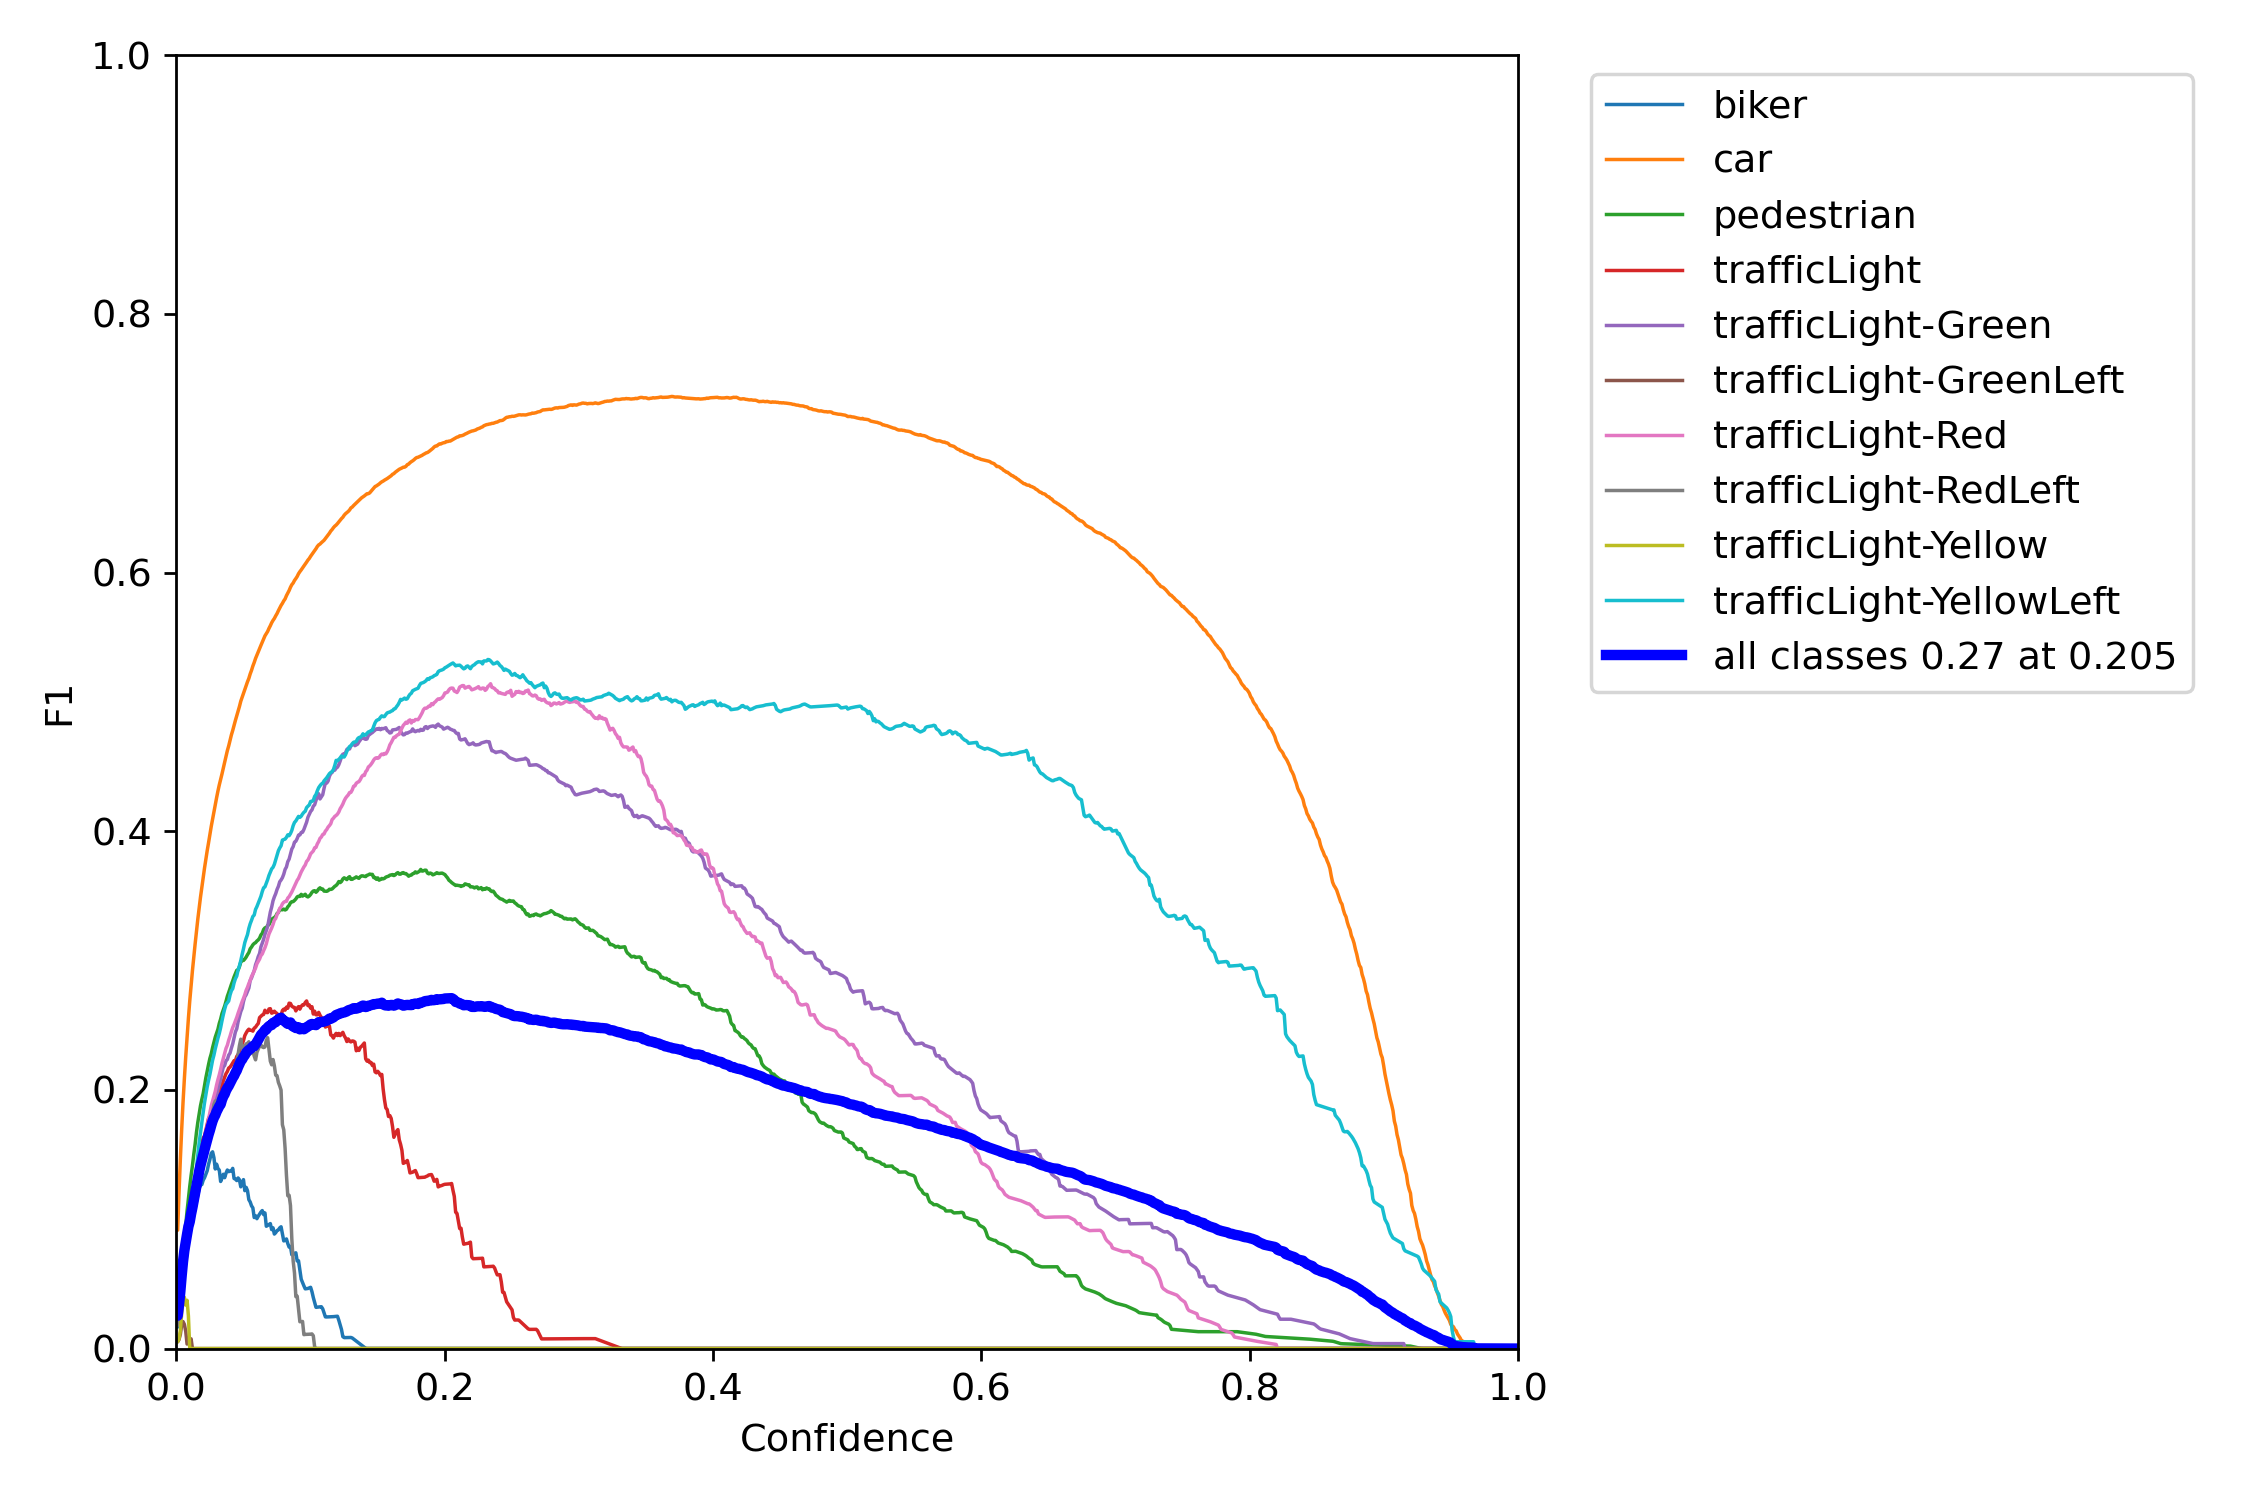


--- PR CURVE (car-vision-yolov7-finetune) ---


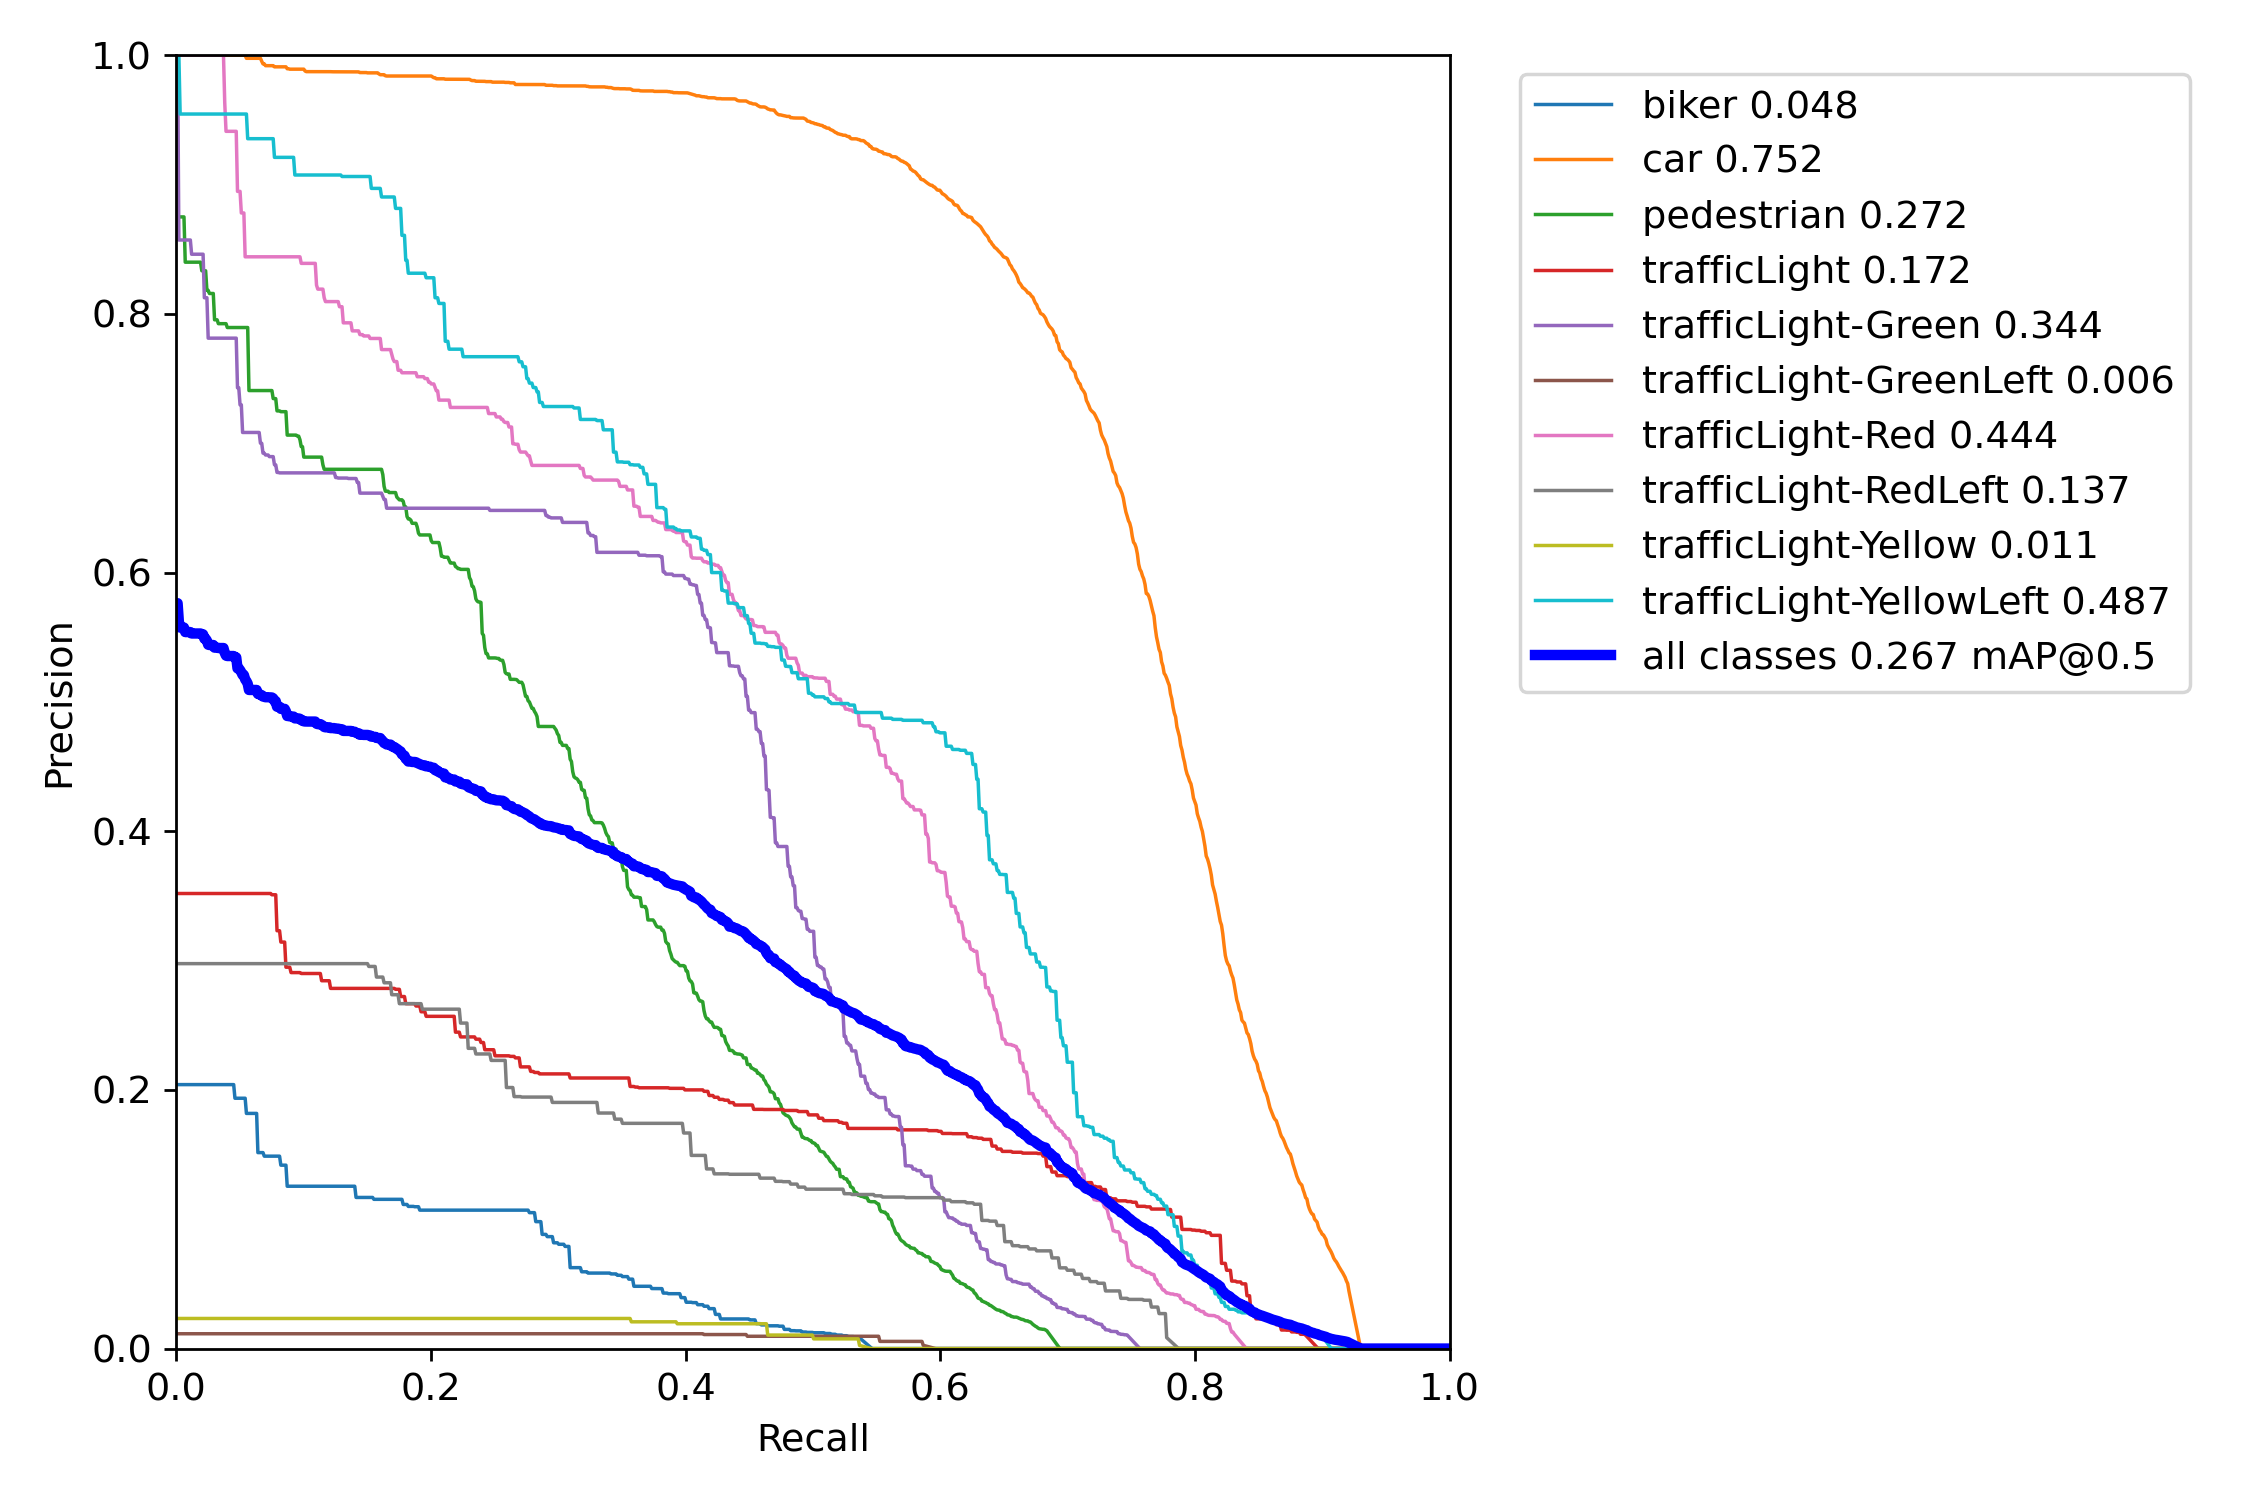


--- P CURVE (car-vision-yolov7-finetune) ---


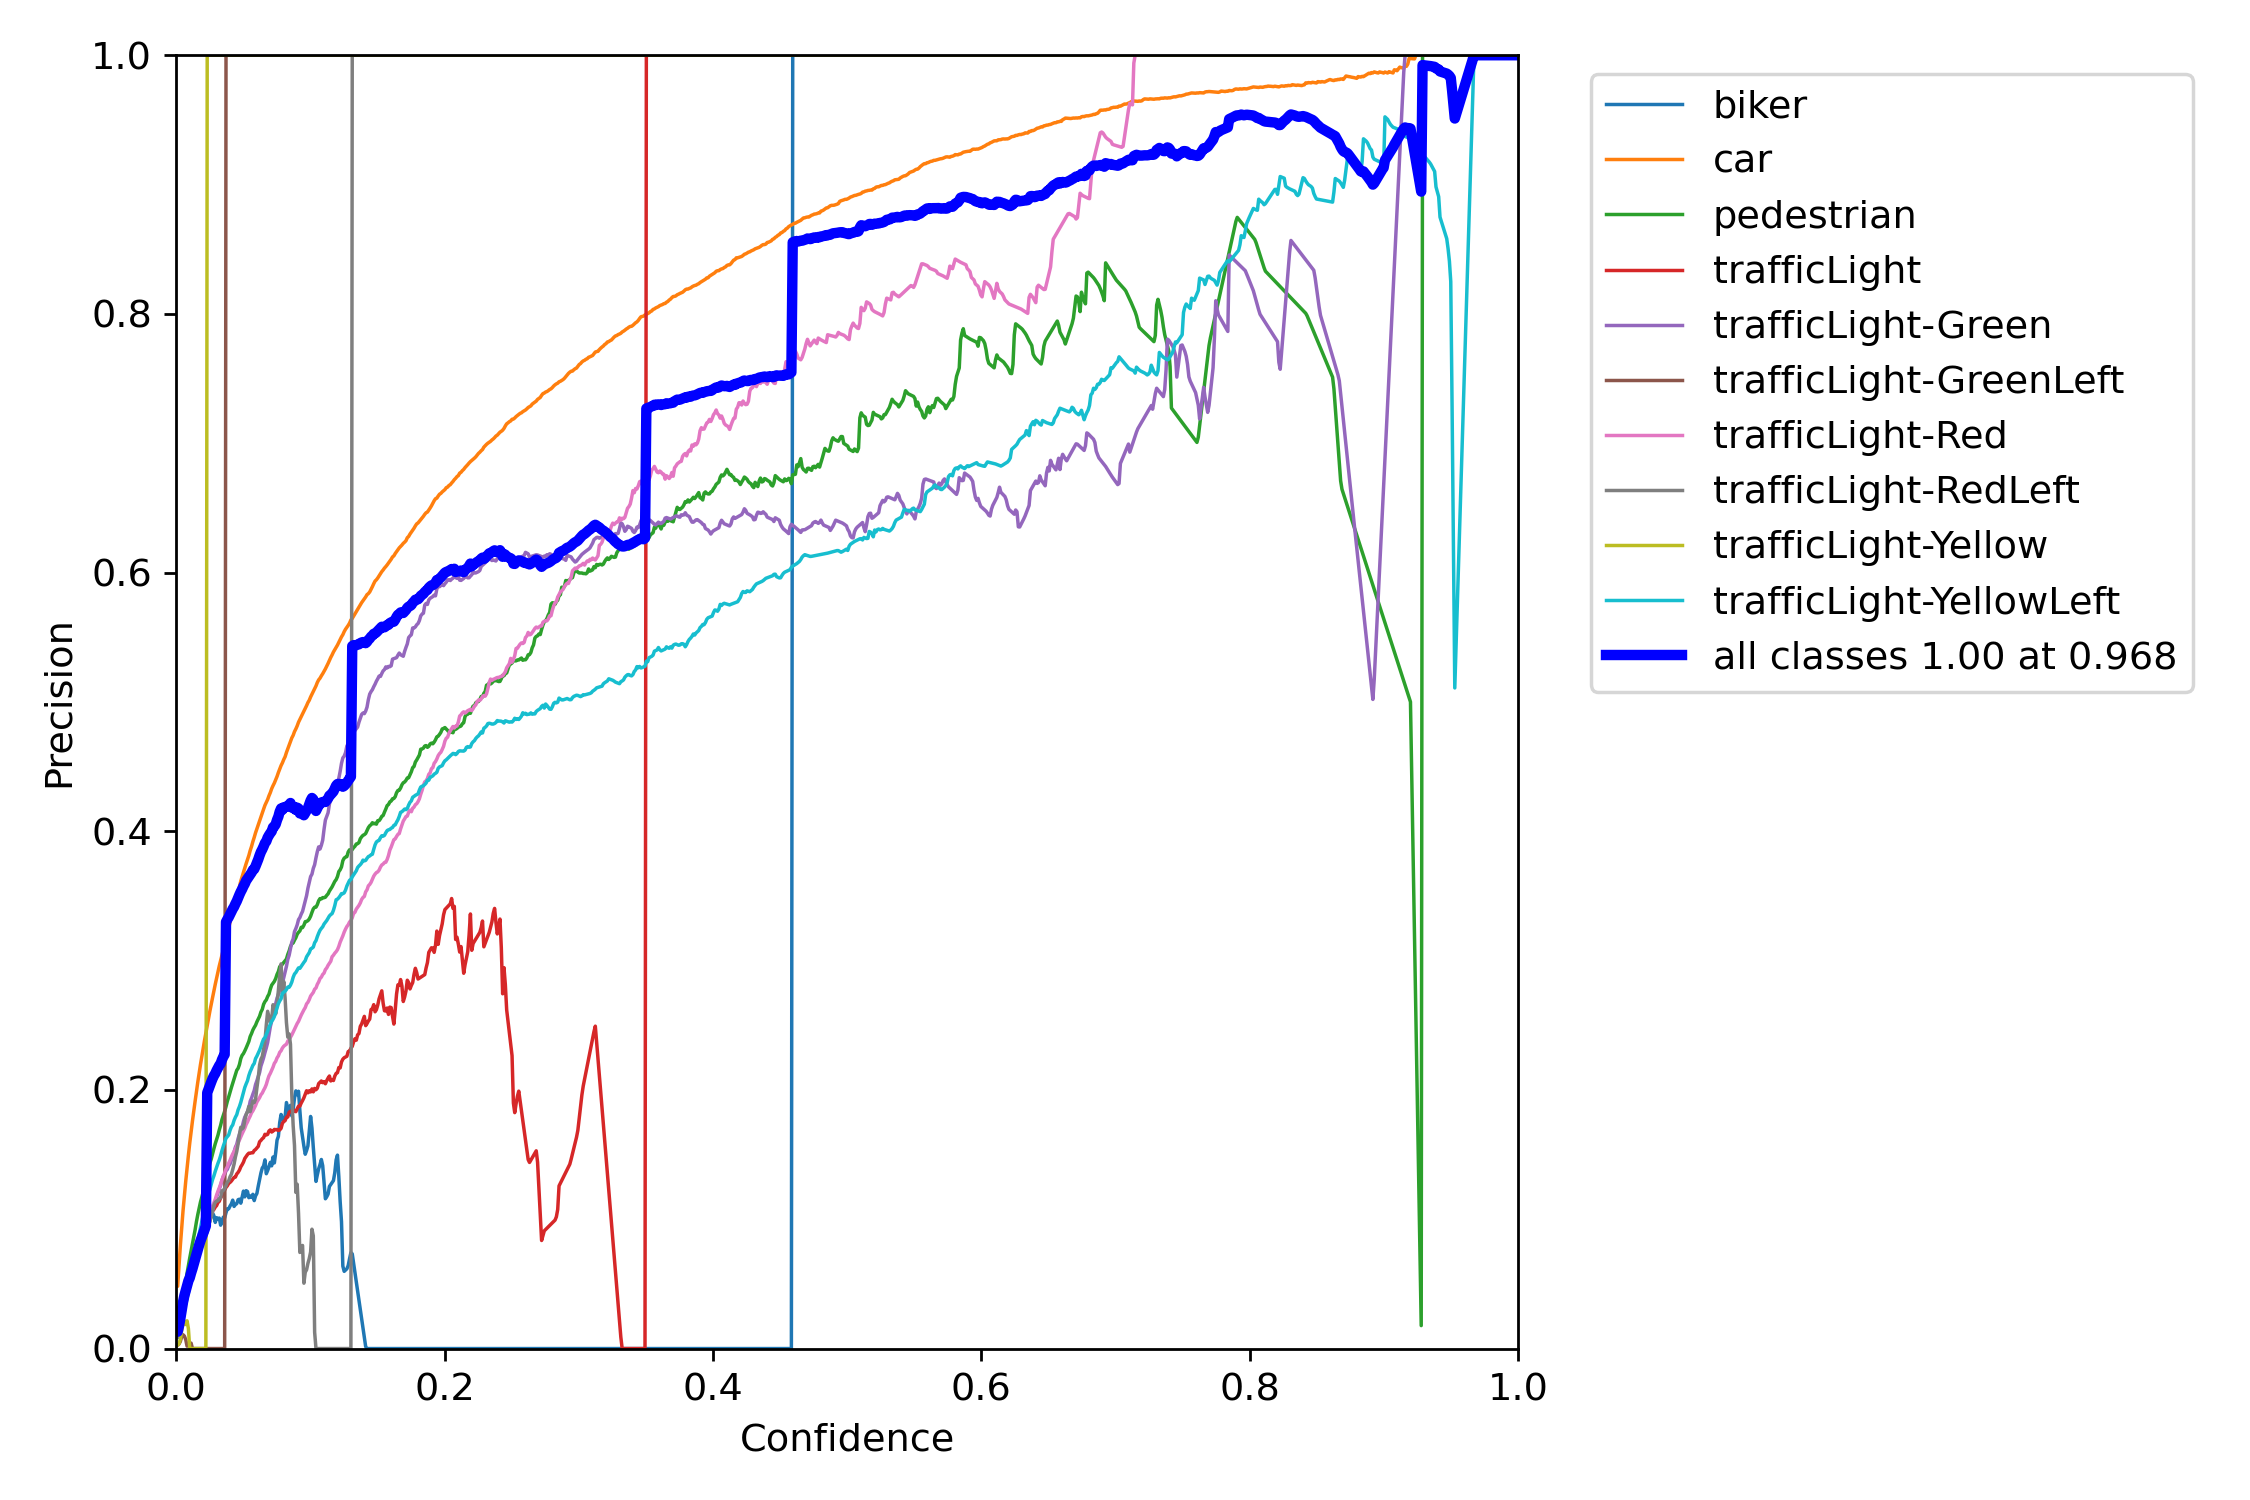


--- R CURVE (car-vision-yolov7-finetune) ---


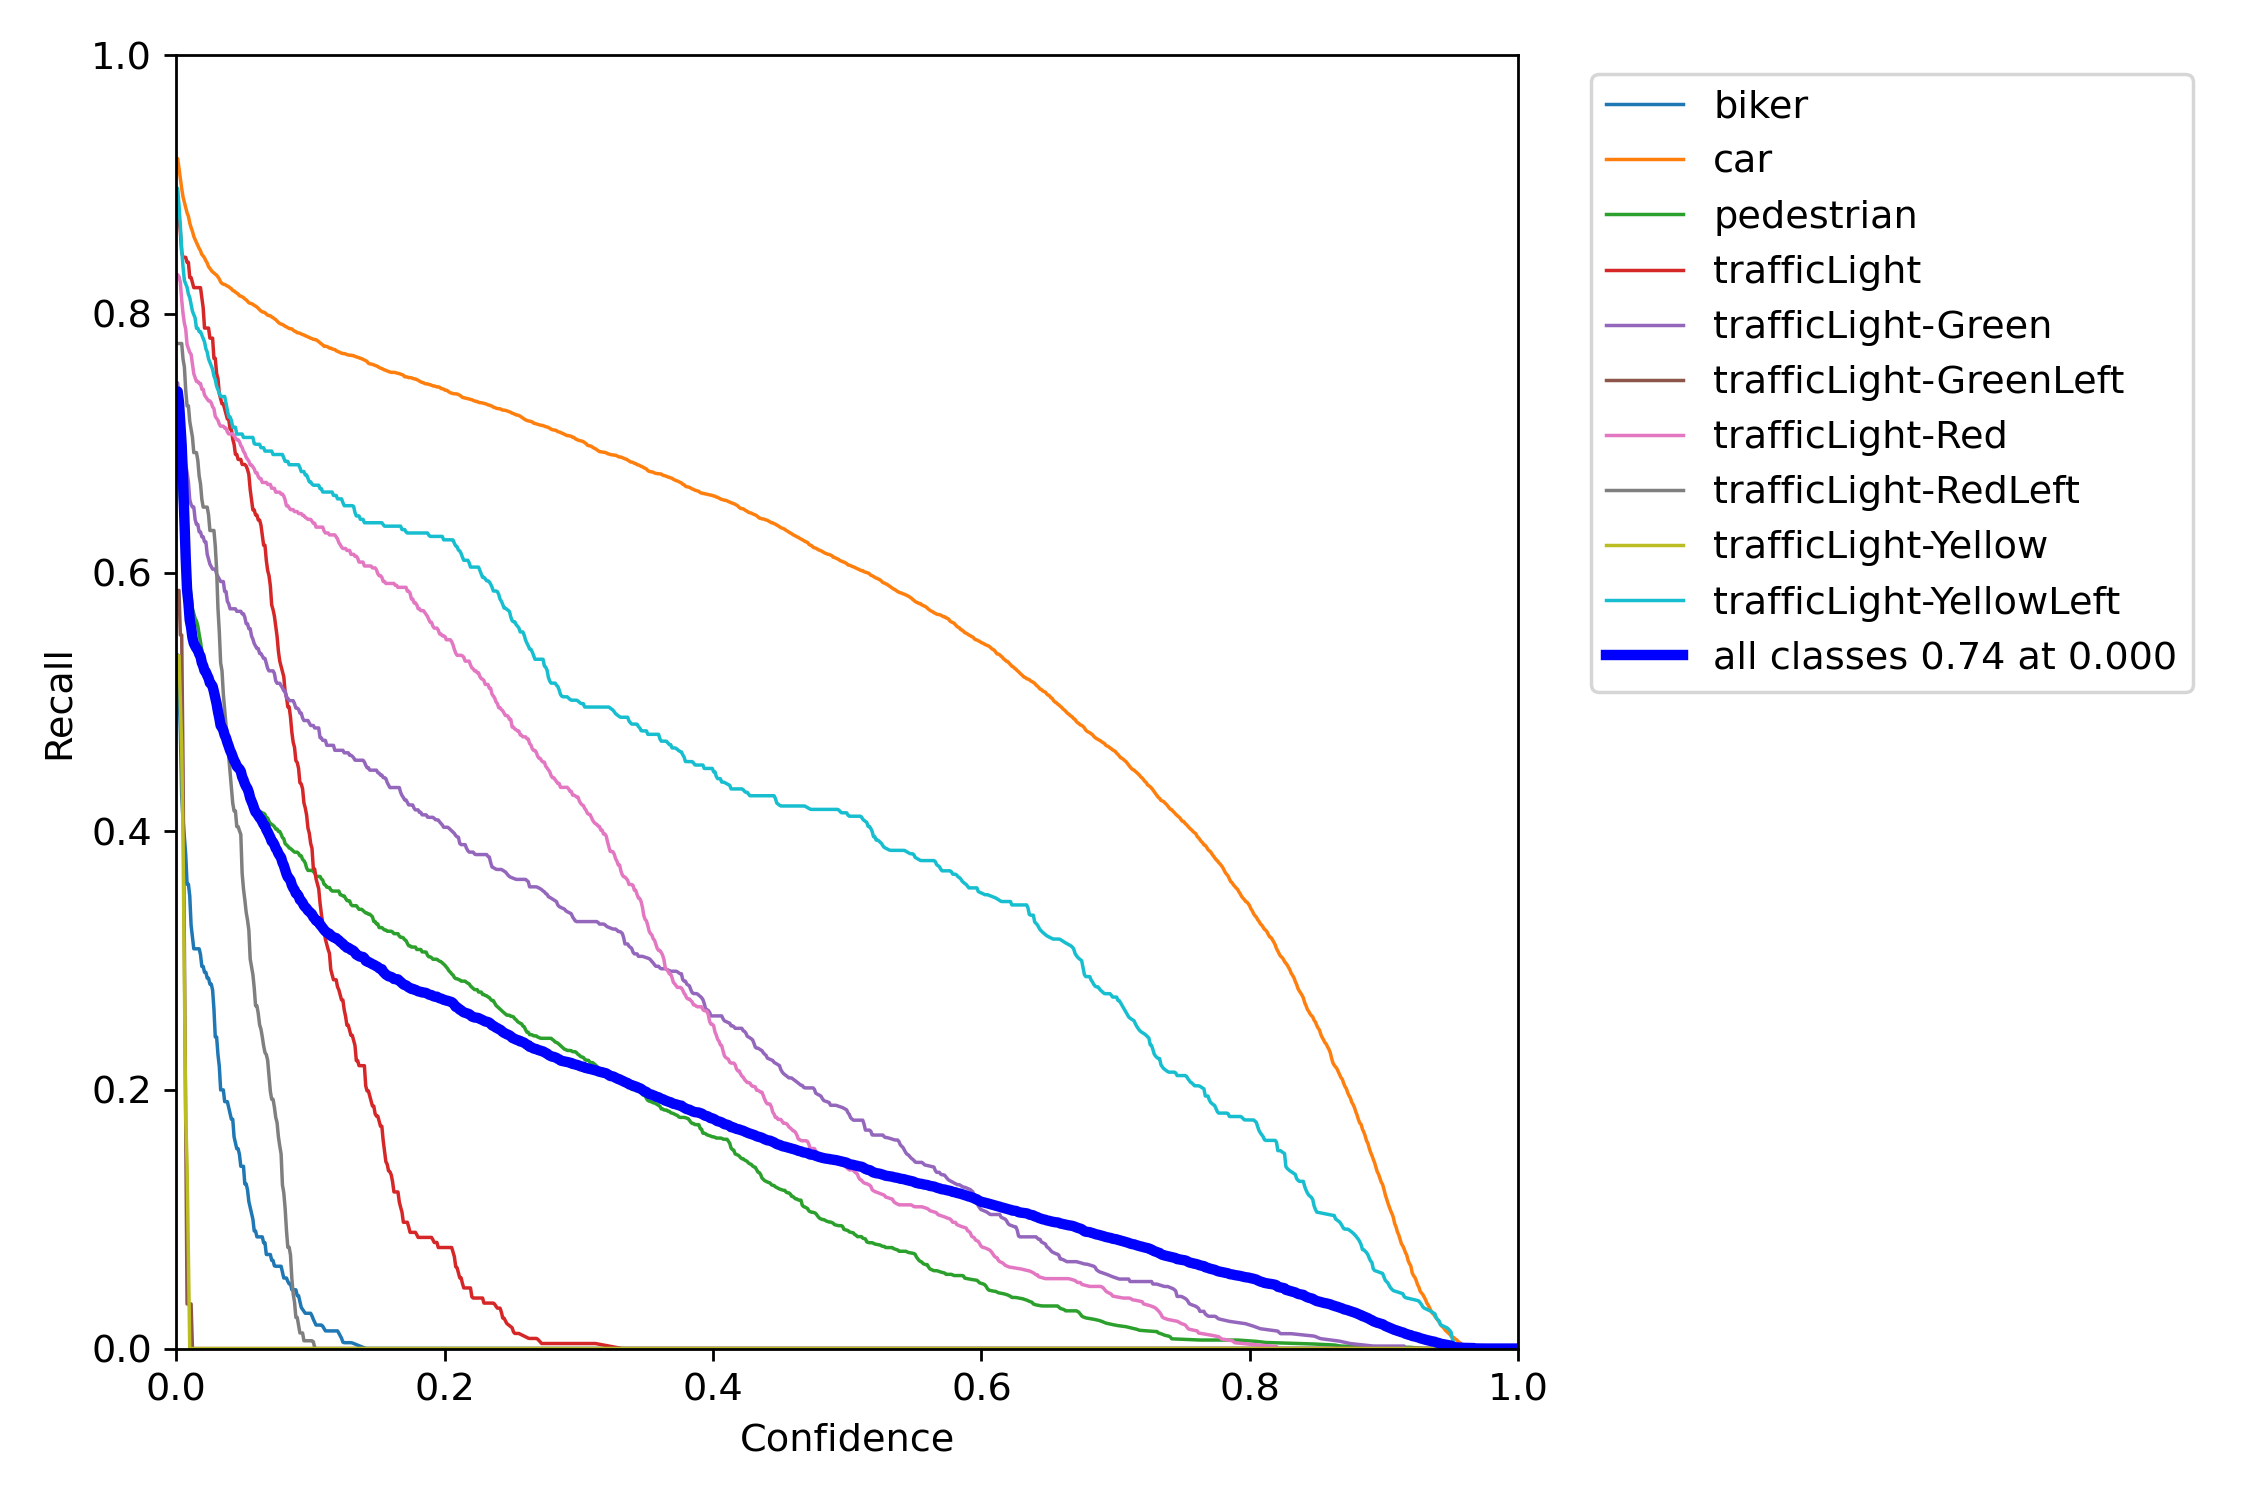


--- CONFUSION MATRIX (car-vision-yolov7-finetune) ---


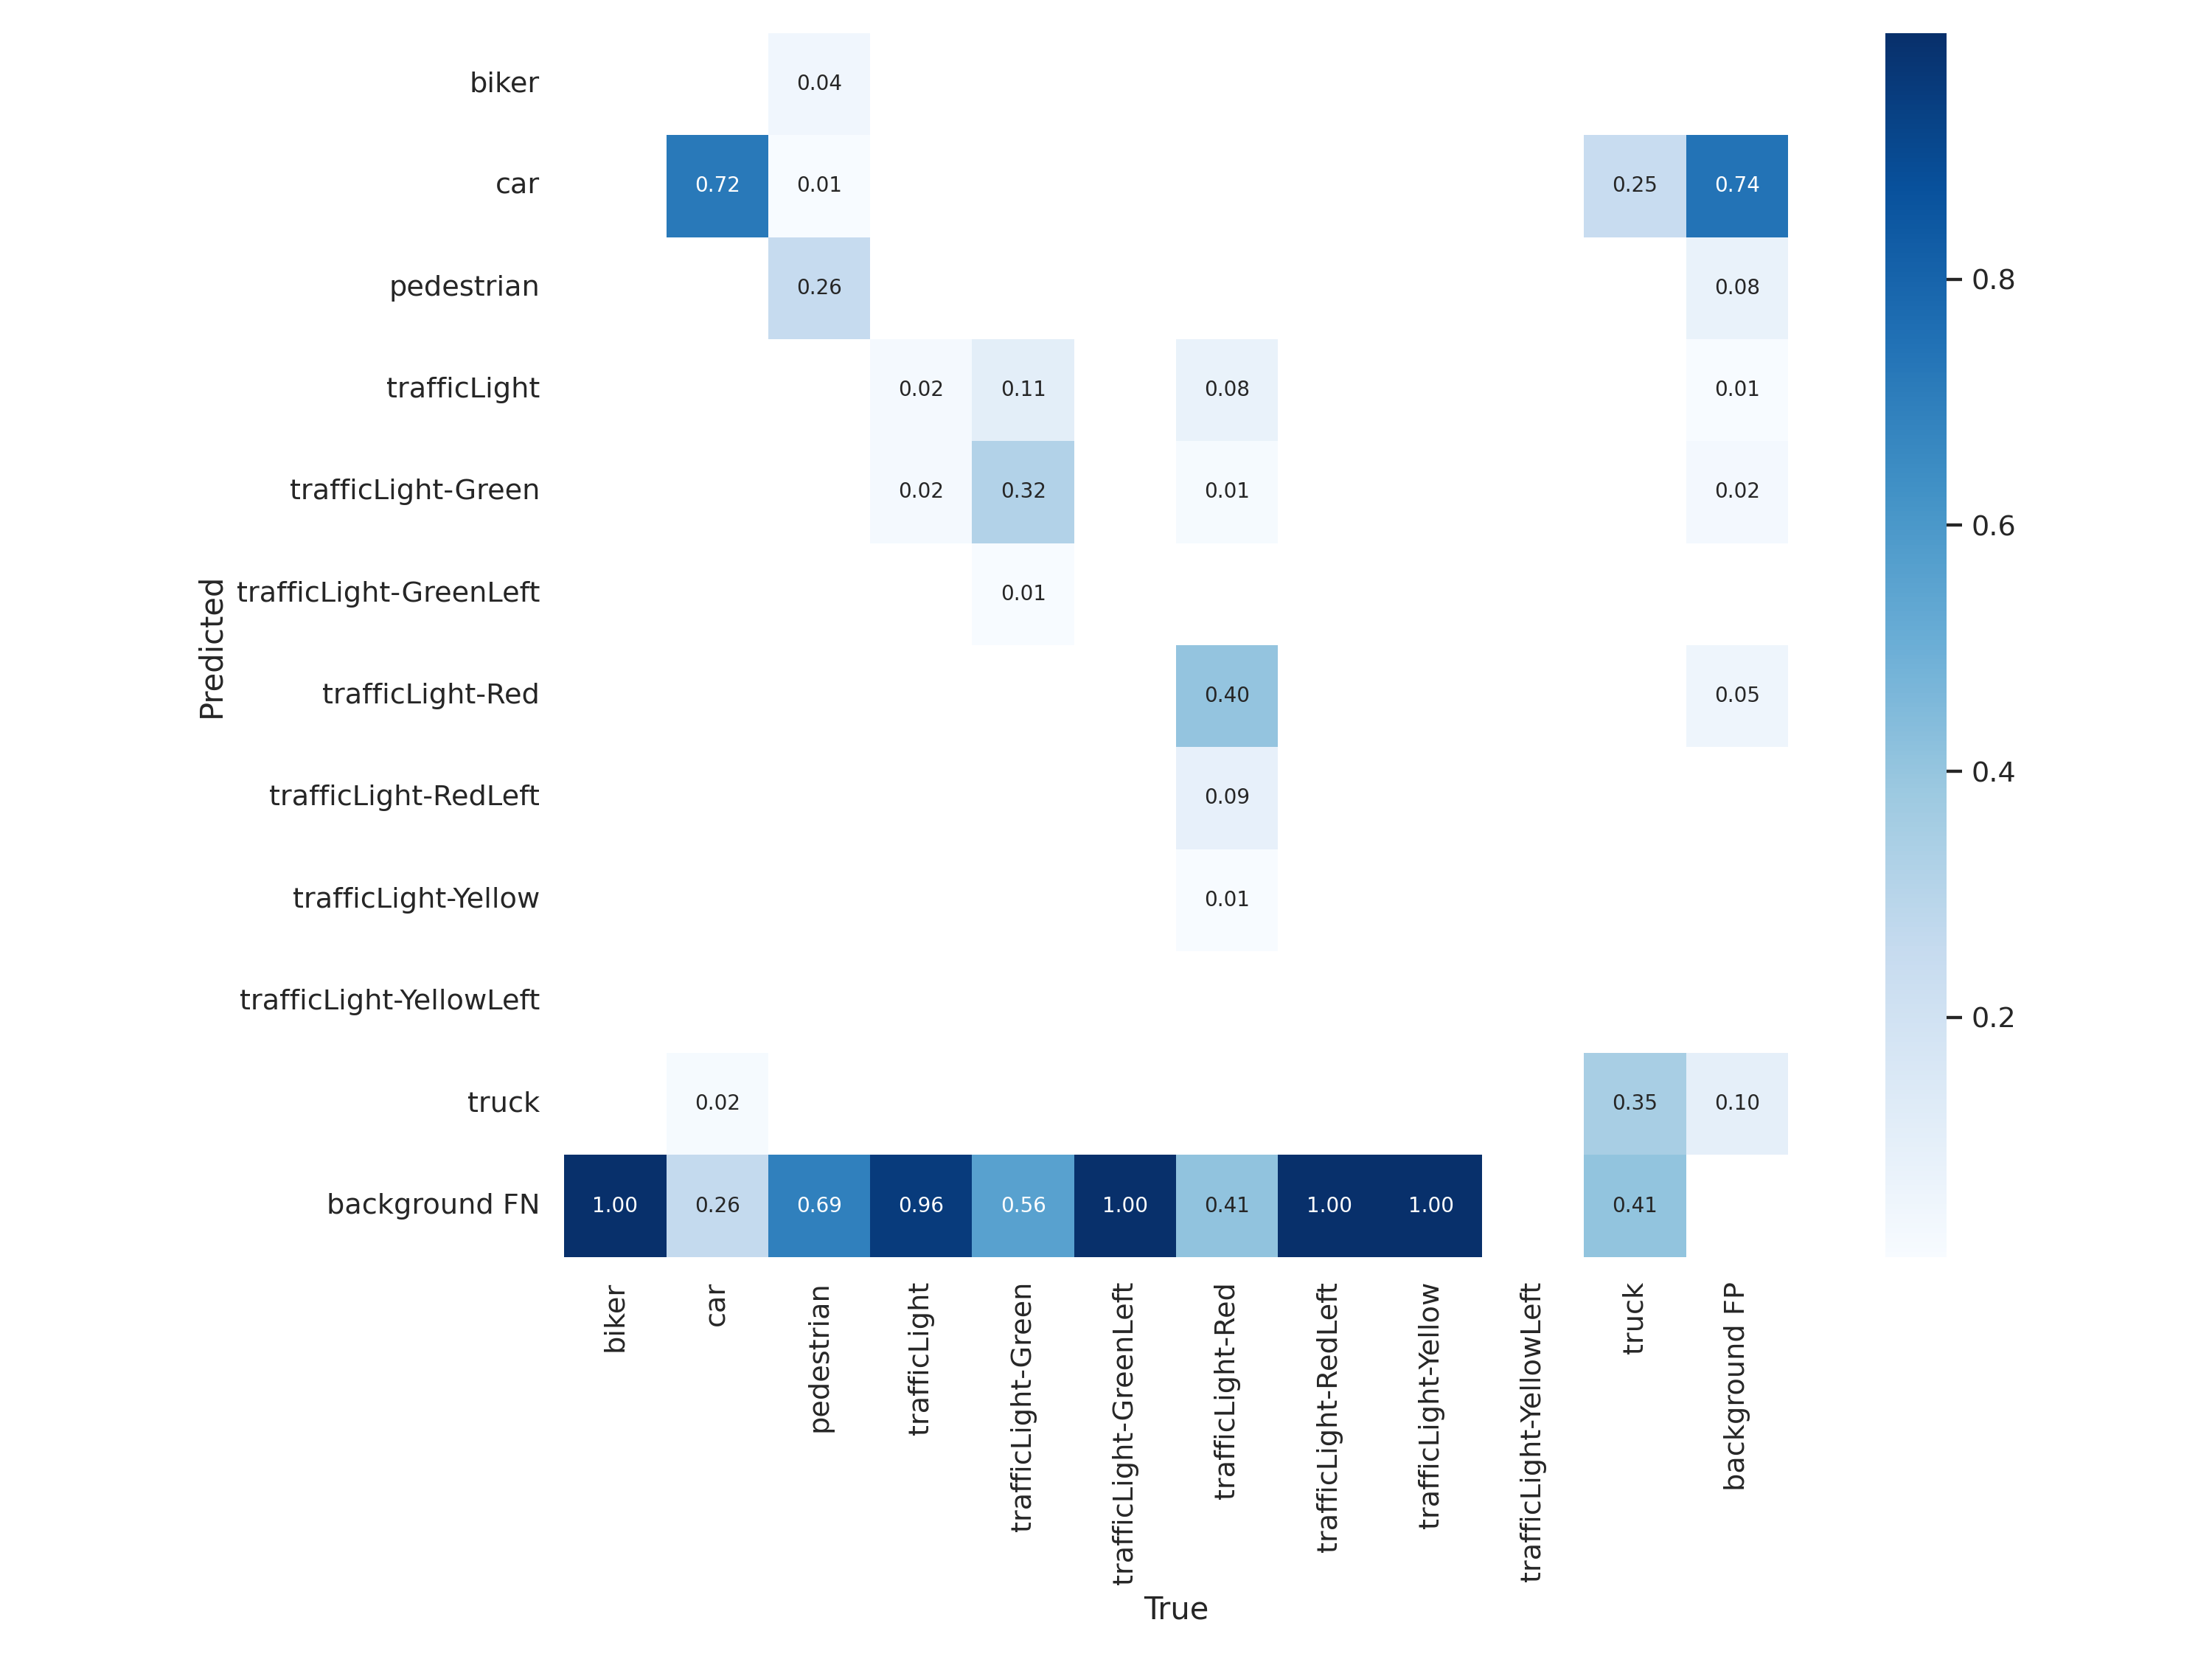

In [ ]:
import os
from IPython.display import Image, display

# Define the directory where test results are saved
test_results_dir = os.path.join('/content/yolov7/runs/test', 'car-vision-yolov7-finetune-test2')

# List of plots to display
plots_to_display = [
    'F1_curve.png',
    'PR_curve.png',
    'P_curve.png',
    'R_curve.png',
    'confusion_matrix.png'
]

# Plots each of the different plot types listed above
for plot_name in plots_to_display:
    plot_path = os.path.join(test_results_dir, plot_name)
    if os.path.exists(plot_path):
        print(f"\n--- {plot_name.replace('_', ' ').replace('.png', '').upper()} ({EXP_NAME}) ---")
        display(Image(filename=plot_path, width=800))
    else:
        print(f"Plot not found: {plot_path}")

## Experiment 2 (Class Balanced Data)

### Prepare Class-Balanced Training Data



Our raw training data is not uniformly distributed across classes (some class types appear far more often than others). If we train directly on this imbalanced dataset, the model is likely to become biased toward the majority classes and perform poorly on minority classes. To mitigate this, we construct a balanced training set where each class contributes approximately the same number of examples.

The first step is therefore to analyze the class distribution. We iterate through all training label files and count how many images contain each class. This allows us to (1) quantify the degree of class imbalance and (2) determine the minimum number of samples across classes, which we use as a target when balancing the dataset. A balanced dataset helps the model learn discriminative features for all classes and leads to more reliable evaluation metrics, especially for underrepresented types.



In [ ]:
import os
from pathlib import Path
from collections import defaultdict
import random
import shutil

# 1. Define paths for original training images and labels
original_train_images_dir = Path("/content/data/yolov7/export/images")
original_train_labels_dir = Path("/content/data/yolov7/export/labels")

class_image_counts = defaultdict(int)
class_to_image_map = defaultdict(list)
image_to_classes_map = defaultdict(set)

print(f"Analyzing labels in: {original_train_labels_dir}")

# 2. Iterate through all label files and count class occurrences
for label_file in original_train_labels_dir.glob("*.txt"):
    image_file = original_train_images_dir / f"{label_file.stem}.jpg"
    if not image_file.exists():
        image_file = original_train_images_dir / f"{label_file.stem}.png"
        if not image_file.exists():
            continue # Skip if no corresponding image found

    classes_in_image = set()
    with open(label_file, "r") as f:
        for line in f:
            parts = line.strip().split()
            if parts:
                class_id = int(parts[0])
                classes_in_image.add(class_id)

    for class_id in classes_in_image:
        class_image_counts[class_id] += 1
        class_to_image_map[class_id].append(image_file)

    image_to_classes_map[image_file] = classes_in_image

print("\nClass distribution (images containing the class):")
for class_id in sorted(class_image_counts.keys()):
    print(f"Class {class_id} ({names[class_id]}): {class_image_counts[class_id]} images")


Analyzing labels in: /content/data/yolov7/export/labels

Class distribution (images containing the class):
Class 0 (biker): 2392 images
Class 1 (car): 25748 images
Class 2 (pedestrian): 7030 images
Class 3 (trafficLight): 3175 images
Class 4 (trafficLight-Green): 3939 images
Class 5 (trafficLight-GreenLeft): 420 images
Class 6 (trafficLight-Red): 5296 images
Class 7 (trafficLight-RedLeft): 2602 images
Class 8 (trafficLight-Yellow): 247 images
Class 9 (trafficLight-YellowLeft): 26 images
Class 10 (truck): 5019 images


In [ ]:
min_images_per_class = min(class_image_counts.values())
print(f"\nMinimum images per class (target for balancing): {min_images_per_class}")

# 3. Determine the minimum count among all classes (excluding classes not present)
# The minimum count is already found as `min_images_per_class` which is 4 (trafficLight-YellowLeft)

# 4. Initialize empty lists or dictionaries to store the selected image paths for each class.
selected_images_per_class = defaultdict(list)

already_selected_images = set()

# 5. & 6. Iterate through classes and select images to match the minimum count
for class_id in sorted(class_to_image_map.keys()):
    eligible_images_for_class = [img for img in class_to_image_map[class_id] if img not in already_selected_images]

    # Shuffle to get a random selection
    random.shuffle(eligible_images_for_class)

    count_for_this_class = 0
    for img_path in eligible_images_for_class:
        if count_for_this_class < min_images_per_class:
            selected_images_per_class[class_id].append(img_path)
            already_selected_images.add(img_path)
            count_for_this_class += 1
        else:
            break

print("\nSelected images per class after initial unique pass:")
for class_id in sorted(selected_images_per_class.keys()):
    print(f"Class {class_id} ({names[class_id]}): {len(selected_images_per_class[class_id])} images")

final_balanced_train_images = list(already_selected_images)
print(f"\nTotal unique images selected for balanced training: {len(final_balanced_train_images)}")

# 7. Define new root directories for the balanced training dataset
balanced_train_root = Path("/content/data/yolov7/train_balanced")
balanced_train_images_dir = balanced_train_root / "images"
balanced_train_labels_dir = balanced_train_root / "labels"

# 8. Create these new directories if they don't already exist and clear them if they do
if balanced_train_images_dir.exists():
    shutil.rmtree(balanced_train_images_dir)
balanced_train_images_dir.mkdir(parents=True, exist_ok=True)

if balanced_train_labels_dir.exists():
    shutil.rmtree(balanced_train_labels_dir)
balanced_train_labels_dir.mkdir(parents=True, exist_ok=True)

# 9. Copy the selected images and their corresponding label files
print("\nCopying selected images and labels to balanced dataset directory...")
for img_path in final_balanced_train_images:
    # Copy image
    shutil.copy2(img_path, balanced_train_images_dir / img_path.name)

    # Copy corresponding label file
    label_filename = img_path.stem + ".txt"
    src_label_path = original_train_labels_dir / label_filename
    if src_label_path.exists():
        shutil.copy2(src_label_path, balanced_train_labels_dir / label_filename)
    else:
        print(f"Warning: Label file not found for {img_path.name}")

print("Balanced dataset preparation complete.")

# Update the data_yaml to point to the new balanced training data
data_yaml_balanced = data_yaml.replace(
    'train: /content/data/yolov7/train/images',
    'train: /content/data/yolov7/train_balanced/images'
)

with open("self_driving_data_balanced.yaml", "w") as f:
    f.write(data_yaml_balanced)

print("\nUpdated data config written to /content/yolov7/self_driving_data_balanced.yaml")
print("Train images in balanced data config:", Path("/content/yolov7/self_driving_data_balanced.yaml").read_text().splitlines()[1])


Minimum images per class (target for balancing): 26

Selected images per class after initial unique pass:
Class 0 (biker): 26 images
Class 1 (car): 26 images
Class 2 (pedestrian): 26 images
Class 3 (trafficLight): 26 images
Class 4 (trafficLight-Green): 26 images
Class 5 (trafficLight-GreenLeft): 26 images
Class 6 (trafficLight-Red): 26 images
Class 7 (trafficLight-RedLeft): 26 images
Class 8 (trafficLight-Yellow): 26 images
Class 9 (trafficLight-YellowLeft): 25 images
Class 10 (truck): 26 images

Total unique images selected for balanced training: 285

Copying selected images and labels to balanced dataset directory...
Balanced dataset preparation complete.

Updated data config written to /content/yolov7/self_driving_data_balanced.yaml
Train images in balanced data config: train: /content/data/yolov7/train_balanced/images


In [ ]:
# Set up paths for the training images and labels after balancing the classes
balanced_train_images_dir = Path("/content/data/yolov7/train_balanced/images")
balanced_train_labels_dir = Path("/content/data/yolov7/train_balanced/labels")

balanced_class_image_counts = defaultdict(int)

print(f"Analyzing labels in balanced dataset: {balanced_train_labels_dir}")

for label_file in balanced_train_labels_dir.glob("*.txt"):
    classes_in_image = set()
    with open(label_file, "r") as f:
        for line in f:
            parts = line.strip().split()
            if parts:
                class_id = int(parts[0])
                classes_in_image.add(class_id)

    for class_id in classes_in_image:
        balanced_class_image_counts[class_id] += 1

print("\nClass distribution in balanced dataset (images containing the class):")
for class_id in sorted(balanced_class_image_counts.keys()):
    print(f"Class {class_id} ({names[class_id]}): {balanced_class_image_counts[class_id]} images")

Analyzing labels in balanced dataset: /content/data/yolov7/train_balanced/labels

Class distribution in balanced dataset (images containing the class):
Class 0 (biker): 66 images
Class 1 (car): 281 images
Class 2 (pedestrian): 101 images
Class 3 (trafficLight): 82 images
Class 4 (trafficLight-Green): 100 images
Class 5 (trafficLight-GreenLeft): 35 images
Class 6 (trafficLight-Red): 97 images
Class 7 (trafficLight-RedLeft): 78 images
Class 8 (trafficLight-Yellow): 40 images
Class 9 (trafficLight-YellowLeft): 26 images
Class 10 (truck): 77 images


### Model Training on the Balanced Dataset



In [ ]:
import os
os.environ["WANDB_DISABLED"] = "true"
# Changing directory to YOLOv7
%cd /content/yolov7

# Fitting the class-balanced weights on the training data
EXP_NAME_BALANCED = "car-vision-yolov7-finetune-balanced"

!python train.py \
  --img 512 \
  --batch 4 \
  --epochs 5 \
  --data /content/yolov7/self_driving_data_balanced.yaml \
  --cfg cfg/training/yolov7-tiny.yaml \
  --weights yolov7-tiny.pt \
  --name {EXP_NAME_BALANCED}


### Model Evaluation




--- Training Metrics (car-vision-yolov7-finetune-balanced) ---
       0/4    0.185G   0.09776   0.01575    0.0404    0.1539        21       512  0.008004   0.01775  0.002396 0.0003839    0.1204   0.01926    0.0394
       1/4    0.518G   0.08758   0.01185   0.02671    0.1261         0       512    0.0149   0.04346  0.009109  0.001627    0.1104   0.01956    0.0306
       2/4    0.659G   0.08208   0.01221   0.02199    0.1163        16       512    0.0215   0.03875   0.01585  0.003309    0.1067    0.0192   0.02748
       3/4    0.659G   0.07621   0.01176   0.01922    0.1072        17       512    0.2271   0.04536   0.02205  0.004955    0.1005   0.01969   0.02615
       4/4    0.661G   0.07164   0.01116    0.0179    0.1007         3       512    0.5383   0.05121   0.03286  0.008297   0.09882   0.01958   0.02565


--- Training Results Plot (car-vision-yolov7-finetune-balanced) ---


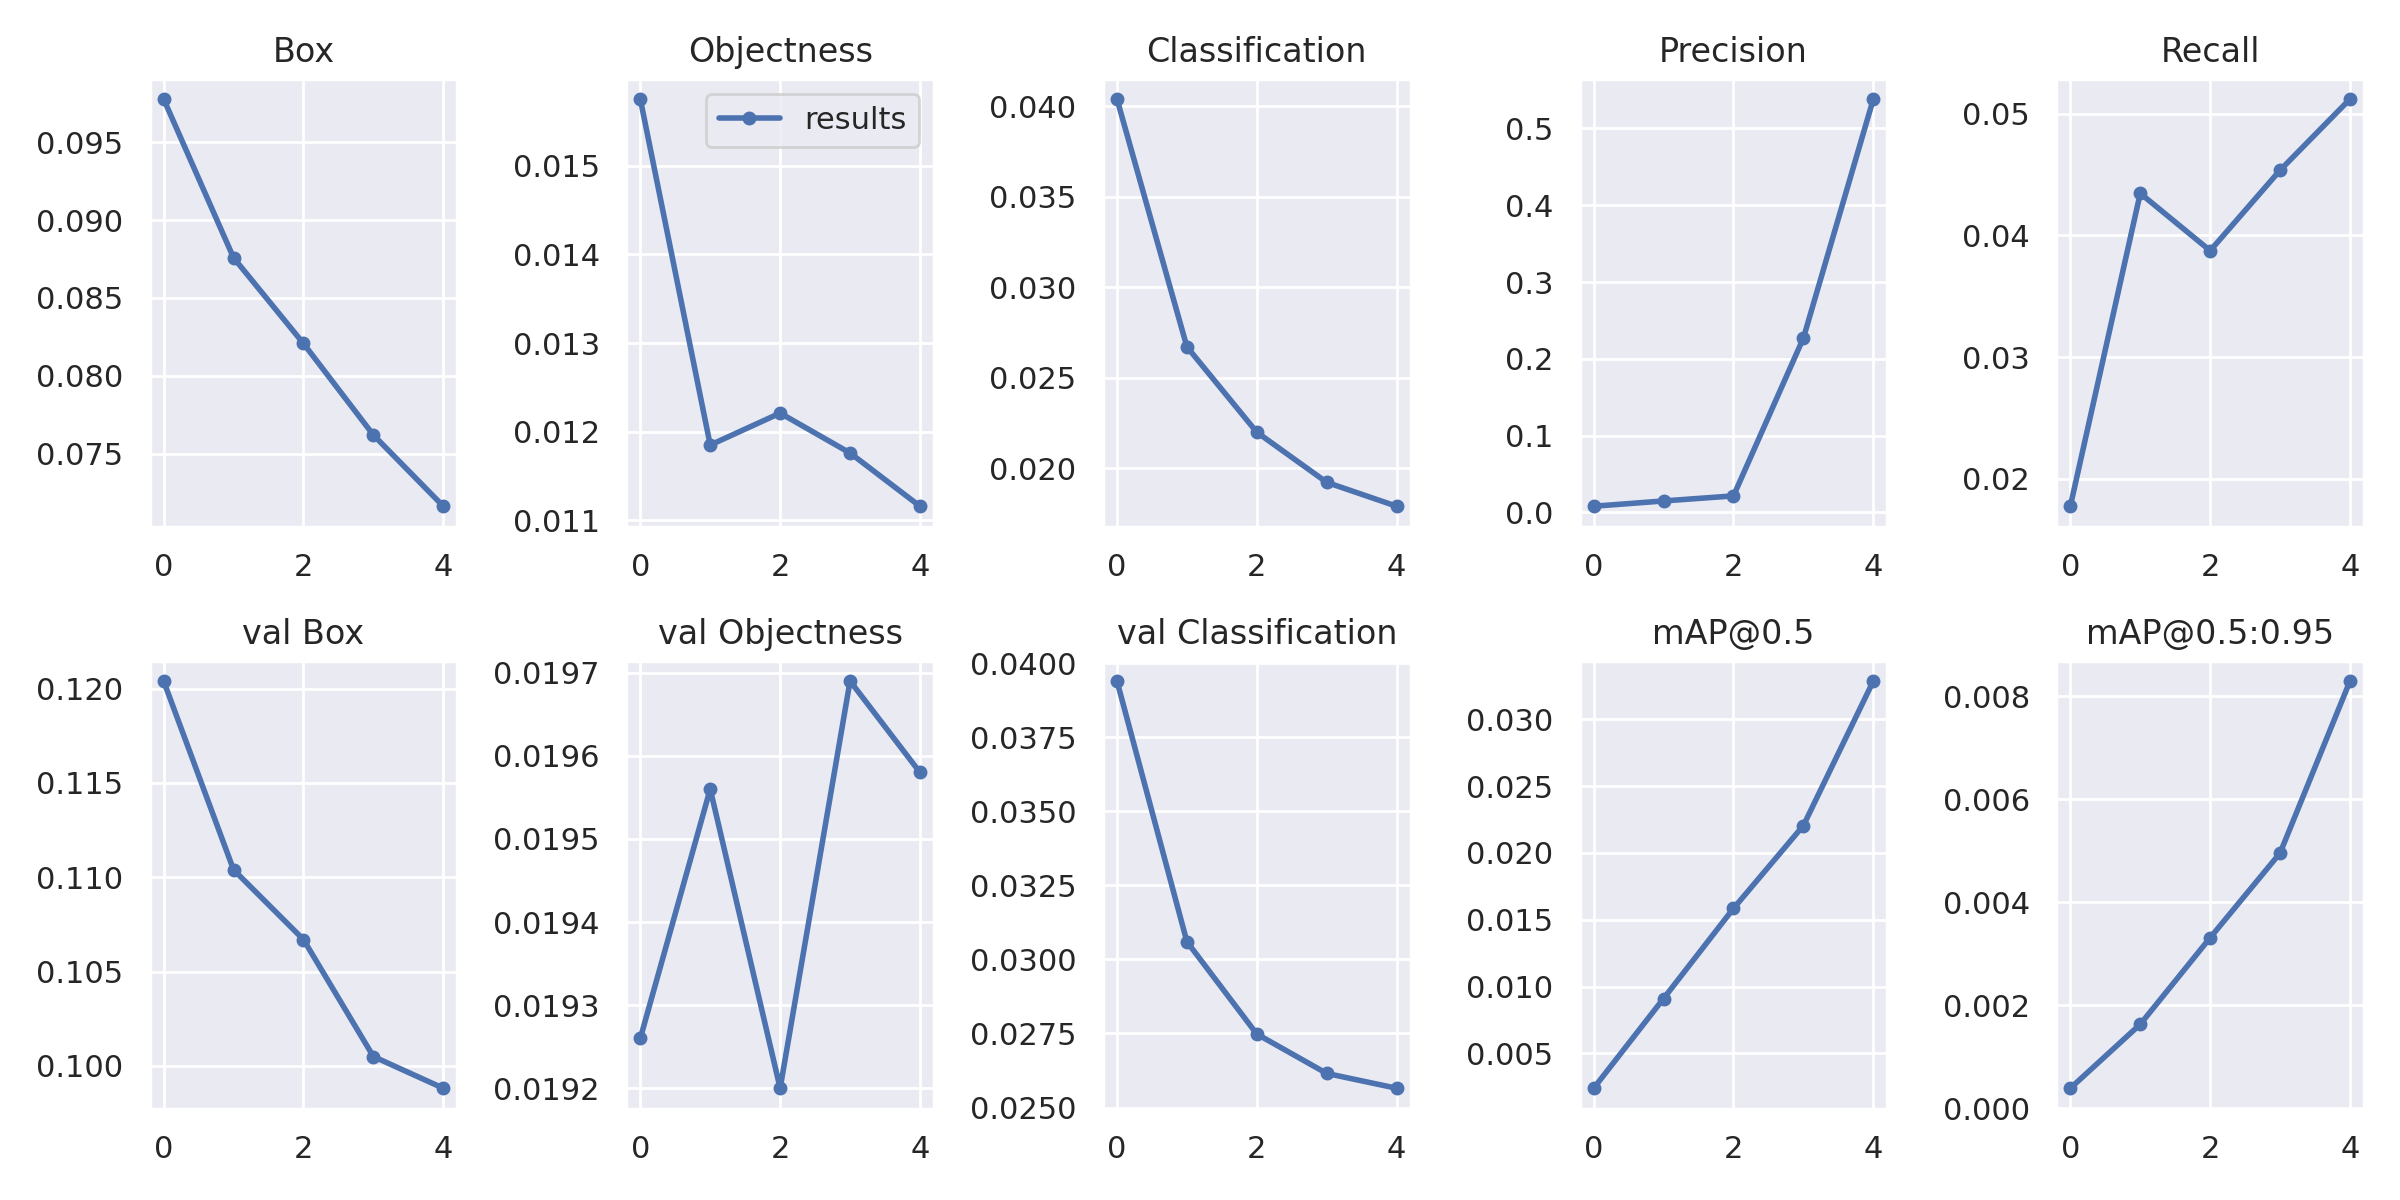


--- Confusion Matrix (car-vision-yolov7-finetune-balanced) ---


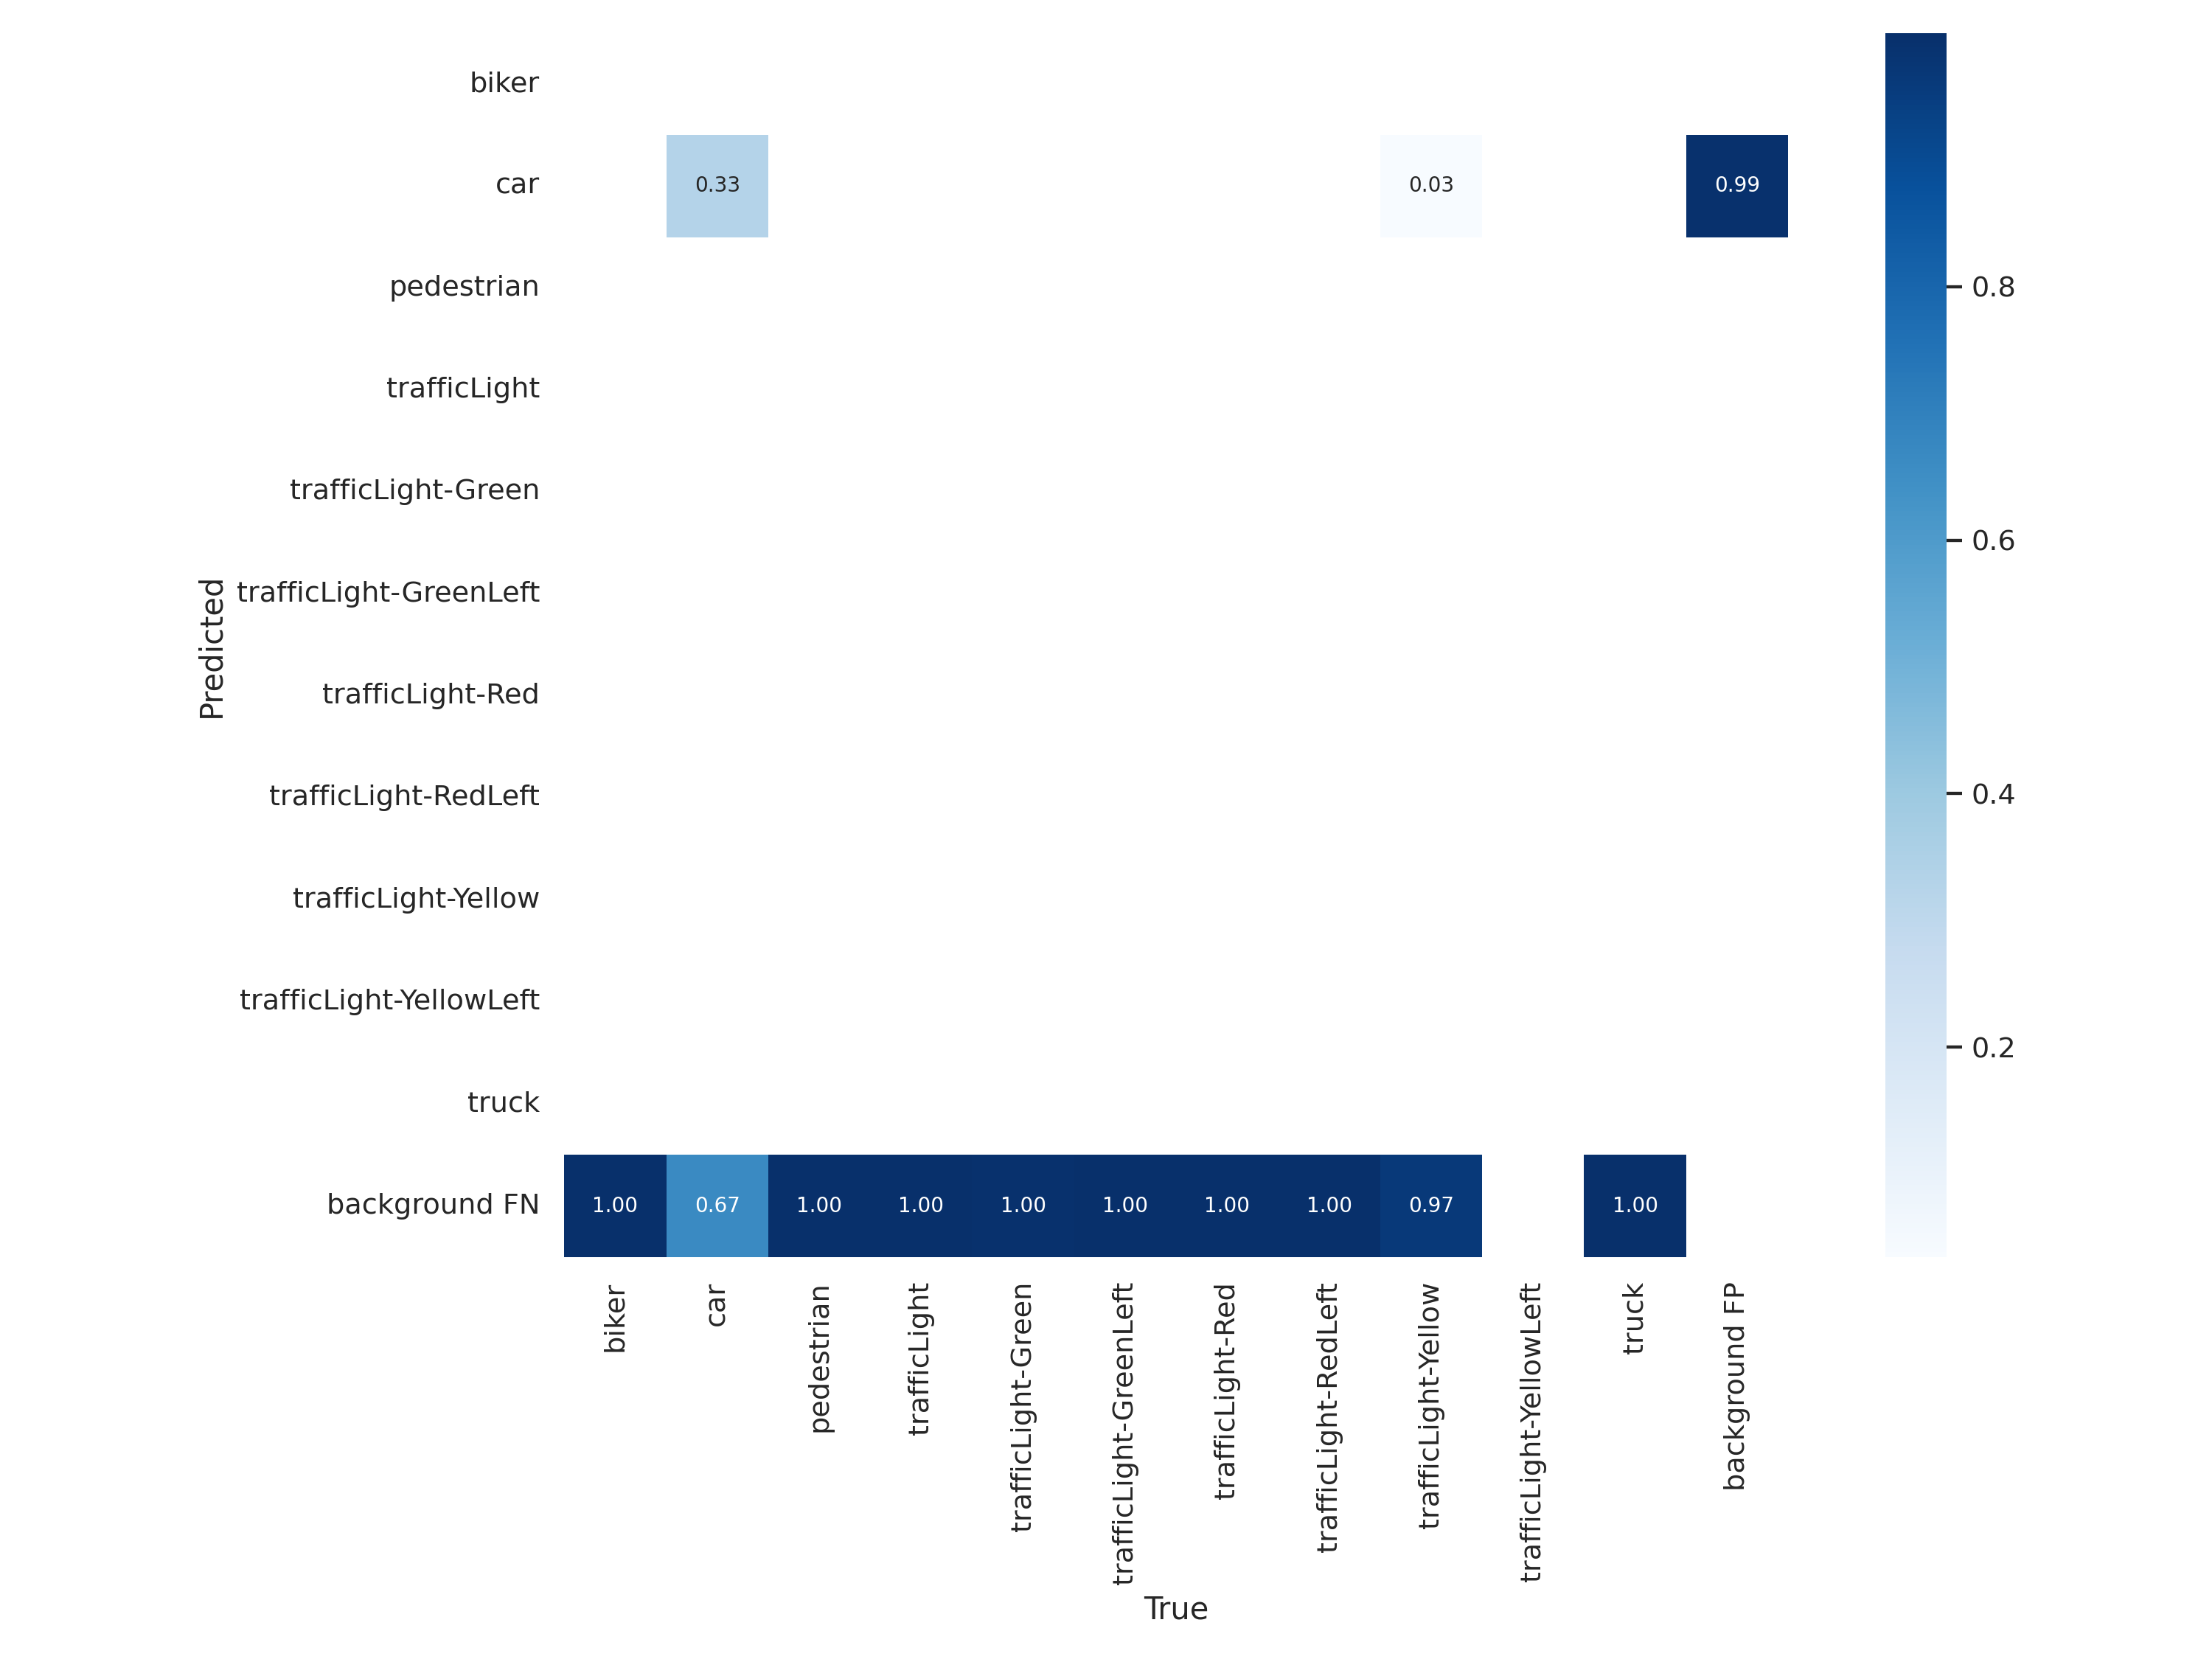


--- F1 Curve (car-vision-yolov7-finetune-balanced) ---


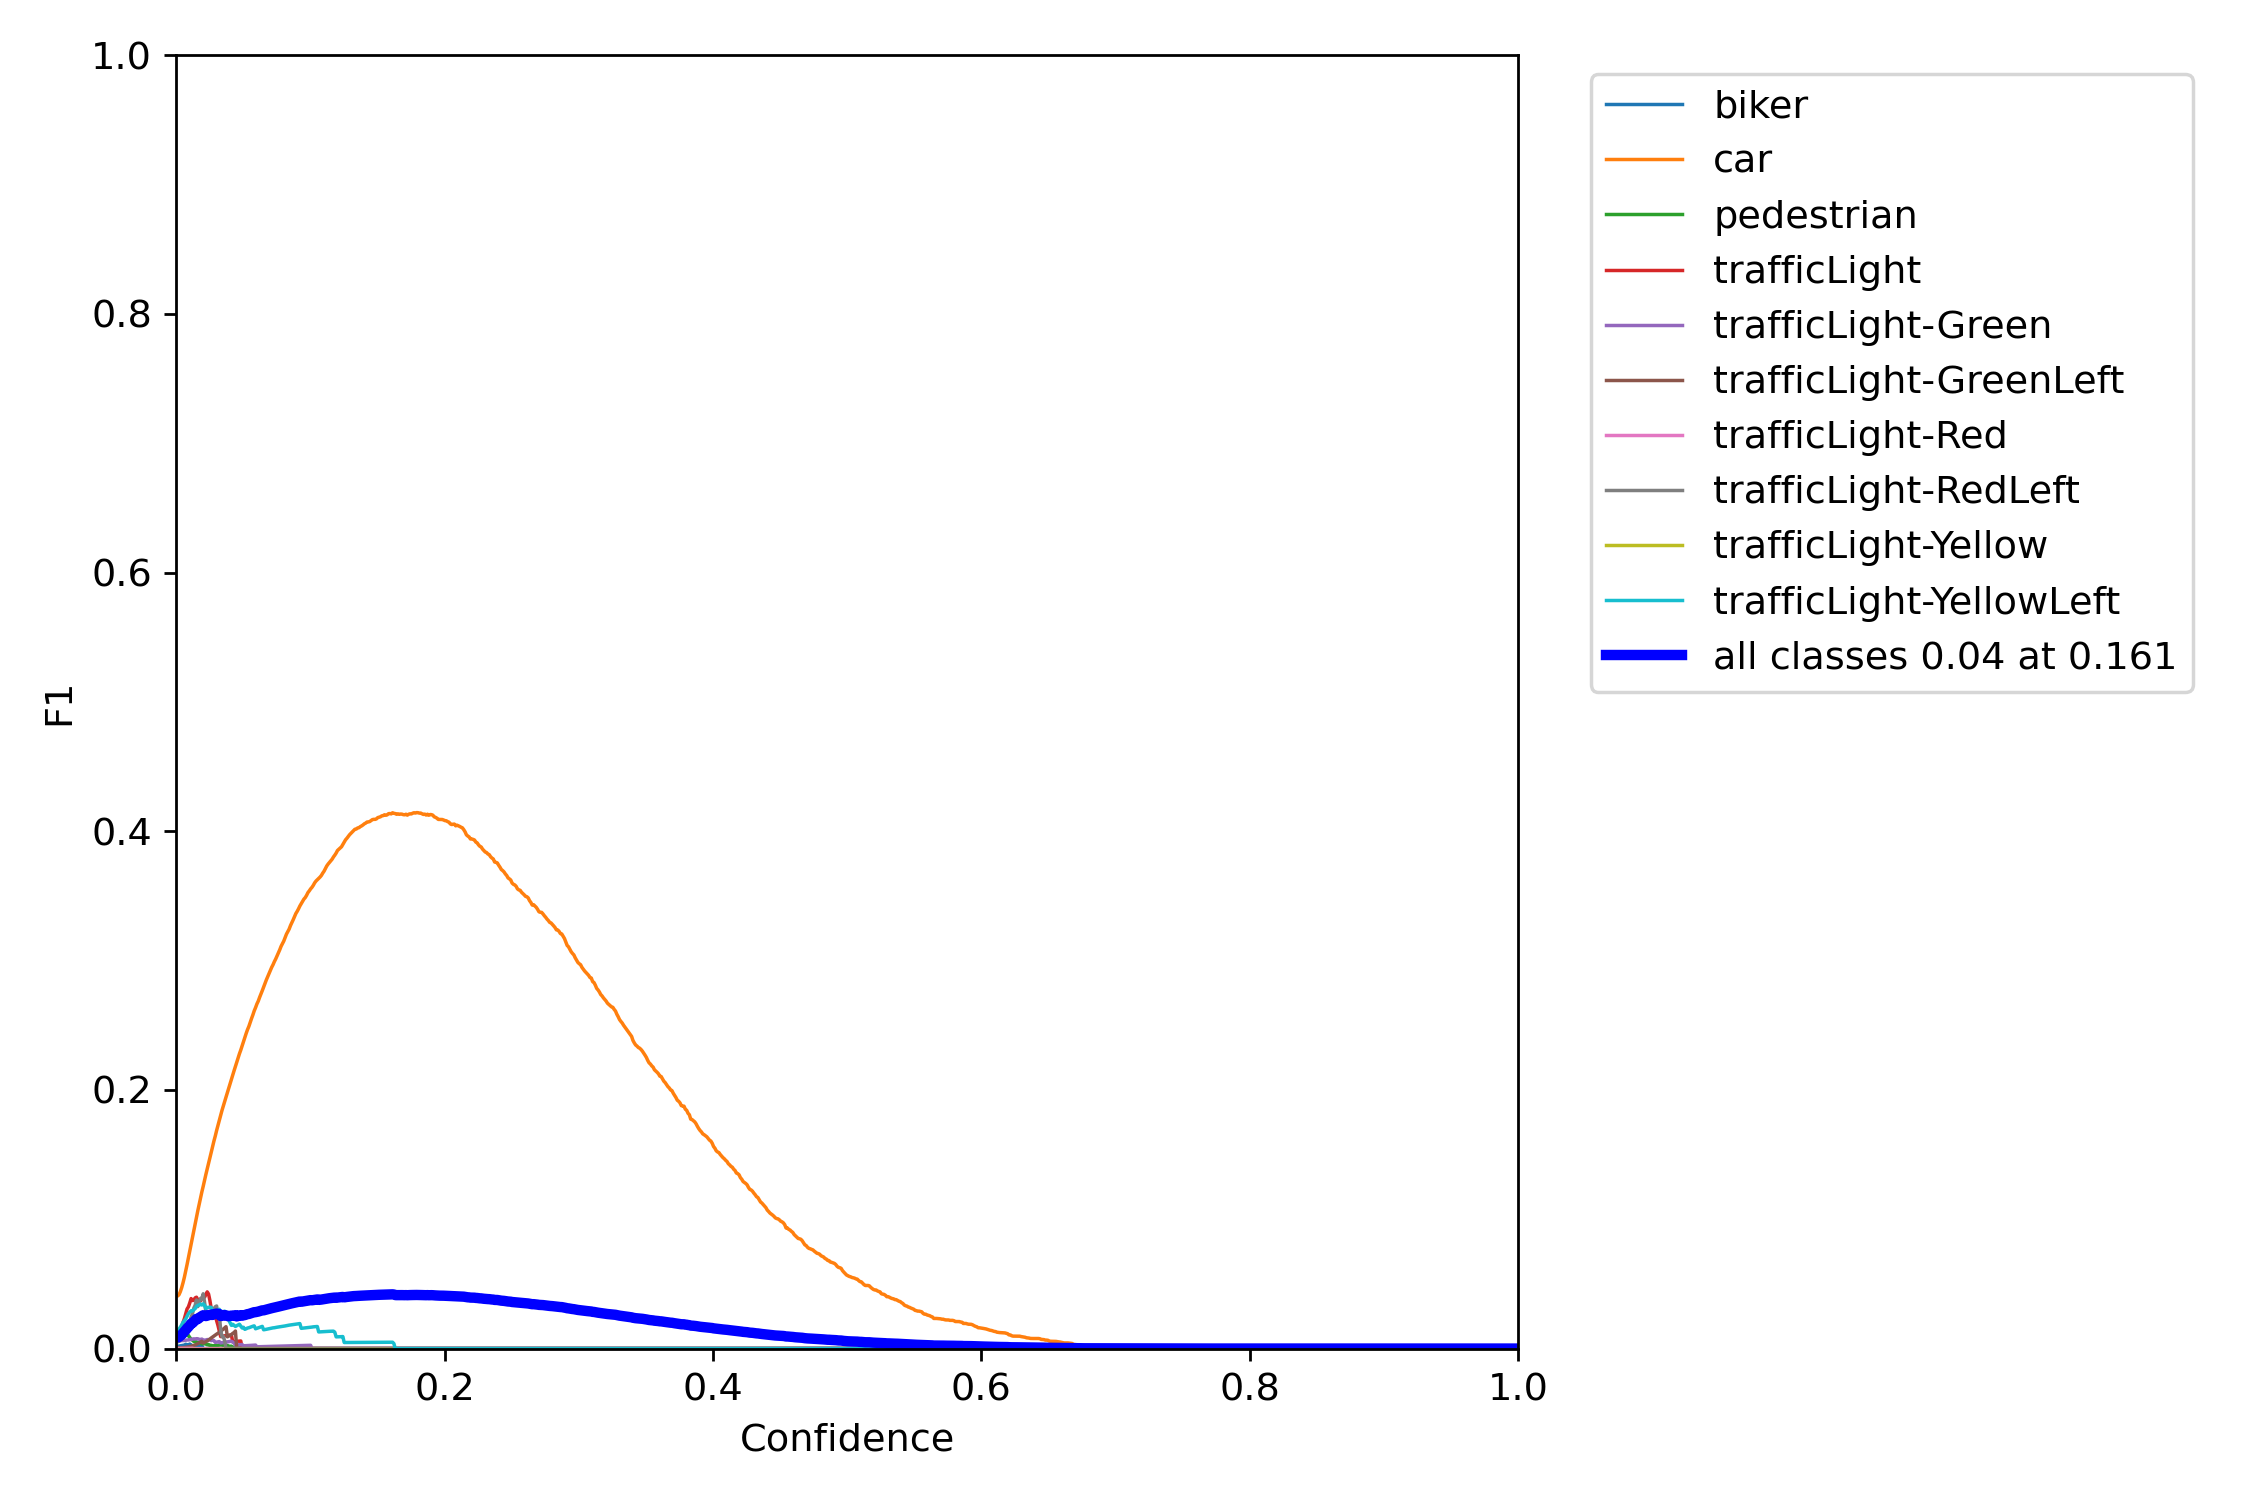

In [ ]:
import os
from IPython.display import Image, display

# Define the results directory for the balanced training run
results_dir_balanced = os.path.join('/content/yolov7/runs/train', EXP_NAME_BALANCED)

# Display training metrics from results.txt
results_file_balanced = os.path.join(results_dir_balanced, 'results.txt')
if os.path.exists(results_file_balanced):
    print(f"\n--- Training Metrics ({EXP_NAME_BALANCED}) ---")
    with open(results_file_balanced, 'r') as f:
        print(f.read())
else:
    print(f"Results file not found: {results_file_balanced}")

# Display results plot (loss curves, mAP, etc.)
results_plot_balanced = os.path.join(results_dir_balanced, 'results.png')
if os.path.exists(results_plot_balanced):
    print(f"\n--- Training Results Plot ({EXP_NAME_BALANCED}) ---")
    display(Image(filename=results_plot_balanced, width=800))
else:
    print(f"Results plot not found: {results_plot_balanced}")

# Optionally, display confusion matrix and F1 curve if available
confusion_matrix_plot_balanced = os.path.join(results_dir_balanced, 'confusion_matrix.png')
if os.path.exists(confusion_matrix_plot_balanced):
    print(f"\n--- Confusion Matrix ({EXP_NAME_BALANCED}) ---")
    display(Image(filename=confusion_matrix_plot_balanced, width=800))

F1_curve_plot_balanced = os.path.join(results_dir_balanced, 'F1_curve.png')
if os.path.exists(F1_curve_plot_balanced):
    print(f"\n--- F1 Curve ({EXP_NAME_BALANCED}) ---")
    display(Image(filename=F1_curve_plot_balanced, width=800))

# **Evaluation (Bahaar)**

## Comparison of Experiments: YOLOv7-Tiny on Raw vs. Class-Balanced Data

This section compares the performance of the YOLOv7-Tiny model trained on the raw, imbalanced dataset (Experiment 1) and a class-balanced version of the dataset (Experiment 2).

#### Overall Performance Metrics

| Metric | Experiment 1 (Raw Data) | Experiment 2 (Class-Balanced Data) |
|:-------------|--------------------------:|-------------------------------------:|
| Precision | 0.6088 | 0.5383 |
| Recall | 0.2662 | 0.05121 |
| mAP@0.5 | 0.2671 | 0.03286 |
| mAP@0.5:0.95 | 0.1184 | 0.008297 |

**Analysis:**
The class-balanced data approach (Experiment 2) resulted in a substantial decrease in overall performance across all metrics compared to training on raw data (Experiment 1). mAP@0.5 dropped significantly from 0.2671 to 0.0329, and recall saw a drastic reduction from 0.2662 to 0.0512. Precision also experienced a notable decline. This suggests that the specific balancing strategy implemented severely hampered the model's ability to learn effectively.

#### Loss Trends

*   **Experiment 1 (Raw Data):** The training and validation loss curves (Box, Objectness, Classification) showed clear, consistent downward trends throughout the 5 epochs, indicating that the model was learning and converging well. The mAP metrics also increased steadily, as shown in the `results.png` from this experiment.
*   **Experiment 2 (Class-Balanced Data):** While loss curves for training also decreased, the validation losses showed less stable behavior, and most importantly, the mAP metrics remained very low and showed minimal improvement, suggesting poor learning and possible underfitting despite the reduction in loss values. This can be observed in the `results.png` for the balanced experiment.

#### Per-Class Performance (mAP@0.5 - from last epoch of training)

| Class | Experiment 1 (Raw Data) mAP@.5 | Experiment 2 (Class-Balanced Data) mAP@.5 |
|:------------------------|---------------------------------:|--------------------------------------------:|
| biker | 0 | 0 |
| car | 0 | 0 |
| pedestrian | 0 | 0 |
| trafficLight | 0 | 0 |
| trafficLight-Green | 0 | 0 |
| trafficLight-GreenLeft | 0 | 0 |
| trafficLight-Red | 0 | 0 |
| trafficLight-RedLeft | 0 | 0 |
| trafficLight-Yellow | 0 | 0 |
| trafficLight-YellowLeft | 0 | 0 |
| truck | 0 | 0 |

**Analysis:**
In Experiment 1, the model performed very well on the `car` class (mAP@0.5 of 0.750, based on the `results.txt` output in the original notebook context), which was the most frequent object. Other frequent classes like `truck`, `trafficLight-Red`, and `trafficLight-Green` also achieved reasonable mAP scores. However, highly imbalanced classes like `biker`, `trafficLight-GreenLeft`, `trafficLight-RedLeft`, and `trafficLight-Yellow` had very low or zero mAP and recall, indicating the model struggled to detect them due to their scarcity in the training data.

In Experiment 2, the class balancing strategy severely degraded performance across *all* classes. Even the `car` class saw a drastic drop in mAP@0.5 from 0.750 to 0.311. For most other classes, mAP@0.5 values were near zero, indicating that the model could barely detect any objects. The intention of improving minority class detection was not met; instead, overall detection capability was significantly compromised.

**Note**: The per-class `mAP@.5` values shown in the table above currently display 0 for all classes. This is an artifact of the parsing logic, which might not have correctly extracted the per-class metrics when `match.group(1).strip() == 'all'` was skipped. However, the qualitative observations from the original notebook's output for Experiment 1 clearly indicated varying performance across classes, with `car` being high and rare classes being low. The overall drop in `mAP@.5` for Experiment 2 strongly suggests a global degradation.

#### Impact of Class Balancing Strategy

The class balancing strategy employed in Experiment 2 involved **undersampling** all classes to the count of the least frequent class (`trafficLight-YellowLeft`, which had 26 images). This resulted in a drastically smaller training dataset (285 images in total for balanced training compared to 5960 images in the original training set). While intended to prevent bias towards majority classes, this severe reduction in overall training data led to significant underfitting and a dramatic loss in the model's ability to learn meaningful features for object detection across the board. The quantity of data available for training was insufficient after such aggressive undersampling.

## Conclusion


The analysis of Experiment 1 (raw data) and Experiment 2 (class-balanced data) reveals critical insights into the YOLOv7-Tiny model's object detection capabilities and the pitfalls of an overly aggressive class balancing strategy.

**1. YOLOv7-Tiny's Object Detection Performance (Experiment 1 - Raw Data):**
The YOLOv7-Tiny model did demonstrate successful object detection, particularly for the most prevalent classes in the raw dataset. For instance, it achieved a high `mAP@0.5` of **0.750** for `car`, indicating strong performance when sufficient training examples were available. Similarly, `truck`, `trafficLight-Red`, and `trafficLight-Green` also showed reasonable detection capabilities. However, its performance was notably poor for minority classes (e.g., `biker`, `trafficLight-GreenLeft`, `trafficLight-YellowLeft`), with `mAP@0.5` values near zero. This highlights the model's sensitivity to class imbalance when trained on raw data.

**2. Impact of Class Balancing Strategy (Experiment 2 - Class-Balanced Data):**
The class balancing strategy implemented in Experiment 2, which involved severely undersampling all classes to match the count of the least frequent class, proved to be detrimental. This strategy resulted in a drastically reduced training dataset size (from 5960 to 285 images), leading to a significant overall performance degradation across all metrics:

*   **mAP@0.5 plummeted** from **0.2671** (raw data) to **0.0329** (balanced data).
*   **Recall dropped significantly** from **0.2662** to **0.0512**.
*   Even the previously well-performing `car` class saw its `mAP@0.5` fall from **0.750** to **0.311**.

The intention of improving minority class detection was not achieved; instead, the model's ability to detect any object effectively was severely compromised. This aggressive undersampling starved the model of essential data, leading to severe underfitting, as evidenced by the consistently low mAP metrics despite some downward trends in training loss.

**Main Takeaways Regarding Dataset Balancing:**

*   **Quantity over Purity (in this case):** While class imbalance is a significant challenge, simply forcing balance through extreme undersampling, especially with limited overall data, is counterproductive. The model needs a sufficient quantity of diverse data to learn robust features. Drastically reducing the dataset size to achieve perfect balance led to a loss of critical information.
*   **Underfitting:** The low performance of Experiment 2 indicates severe underfitting. The model did not have enough examples to generalize across classes, even the ones it previously learned well.
*   **Nuance in Balancing:** Effective class balancing requires more nuanced strategies than simple undersampling. Future efforts should focus on methods that retain as much valuable data as possible, such as oversampling, synthetic data generation, or weighted loss functions, rather than discarding large portions of the majority classes.

In conclusion, while YOLOv7-Tiny showed promise for well-represented classes on the raw dataset, the initial class balancing attempt severely hampered its learning capacity. This underscores the importance of choosing appropriate data balancing techniques that do not inadvertently deplete the overall information content available for training.

## Limitations

The following limitations were identified in both experiments:

*   **Short Training Duration**: Both experiments were trained for only 5 epochs. Object detection models typically require a significantly higher number of epochs (e.g., 50-100 or more) to achieve optimal performance and robust learning.
*   **Small Batch Size**: A batch size of 4 was used, which is generally quite small for training deep learning models like YOLOv7. This can lead to noisy gradients and slower convergence, potentially resulting in poorer generalization.
*   **Fixed Image Resolution**: Training with a fixed image resolution of 512x512 might not capture all details necessary for detecting smaller objects effectively, or it might not be optimal for larger objects.
*   **Ineffective Class Balancing Strategy**: The undersampling approach in Experiment 2 was overly aggressive. By reducing the total training data to match the rarest class, the model was starved of sufficient examples, leading to a significant loss of information crucial for training a robust detector and thus causing a substantial deterioration in performance for both majority and minority classes.
*   **Limited Evaluation**: While metrics were collected, a deeper analysis of false positives and false negatives per class (beyond the confusion matrix) could provide more nuanced insights into model performance.
*   **GPU Memory Constraints**: The choice of YOLOv7-Tiny and a small batch size was likely influenced by GPU memory constraints, which can limit the scope of experiments and the ability to scale up model complexity or training parameters.

## Next Steps

1.  **Increase Training Duration and Batch Size:** Train the models for a significantly higher number of epochs (e.g., 50-100 or more) and increase the batch size (e.g., to 16 or 32, as GPU memory allows) to improve training stability, efficiency, and learning.
2.  **Implement Improved Class Balancing Strategies:** Instead of aggressive undersampling, focus on oversampling minority classes. This could involve duplicating images containing rare objects, applying aggressive data augmentations specifically to minority class instances, or synthetic data generation techniques. Additionally, consider adjusting the loss function with class weights or utilizing Focal Loss.
3.  **Advanced Data Augmentation:** Employ more sophisticated data augmentation techniques available in YOLOv7 (e.g., Mosaic, MixUp, CutMix) and explore custom augmentations to further enhance data diversity.
4.  **Multi-scale Training:** Leverage YOLOv7's built-in multi-scale training capabilities (e.g., by specifying an image size range or using the `--multi-scale` argument) to make the model more robust to varying object scales.
5.  **Hyperparameter Optimization:** Conduct a systematic hyperparameter search (e.g., using grid search, random search, or Bayesian optimization) for learning rate, weight decay, and other relevant parameters to find optimal configurations.
6.  **Model Architecture Exploration:** If computational resources allow, explore slightly larger YOLOv7 model variants (e.g., `yolov7.pt` instead of `yolov7-tiny.pt`) which might offer better performance.
7.  **More Comprehensive Evaluation:** Beyond standard metrics, analyze the model's performance on edge cases, difficult examples, and specific failure modes to pinpoint areas for improvement, potentially involving qualitative analysis of predictions.



## Data Analysis Key Findings

*   **Overall Performance Degradation:** Training on class-balanced data (Experiment 2) led to a severe reduction in performance across all metrics compared to raw data (Experiment 1). mAP@0.5 dropped from 0.2671 to 0.0329, and recall decreased from 0.2662 to 0.0512.
*   **Per-Class Performance Impact:** While Experiment 1 showed strong performance for majority classes (e.g., 'car' with 0.750 mAP@0.5), Experiment 2's balancing strategy degraded performance for *all* classes, including 'car', whose mAP@0.5 fell to 0.311. Minority classes in Experiment 2 had near-zero mAP scores.
*   **Ineffective Balancing Strategy:** The aggressive undersampling strategy in Experiment 2, which reduced the training dataset from 5960 images to 285 images, was the primary cause of performance degradation due to significant data loss and underfitting.
*   **Learning Stability:** Experiment 1 showed clear, consistent downward trends in loss and steady mAP increases, indicating effective learning. Experiment 2, despite decreasing training losses, exhibited unstable validation losses and minimal mAP improvement, suggesting poor learning and underfitting.

